In [1]:
import pandas as pd
import numpy as np
import os
import datetime
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from matplotlib import pyplot
from scipy import stats
from scipy.signal import find_peaks, detrend
import pywt

from numpy import arange, array, linspace, loadtxt, log2, logspace, mean, polyfit
from numpy import zeros, pi, sin, cos, arctan2, sqrt, real, imag, conj, tile
from numpy import round, interp, diff, unique, where
from pandas import DataFrame, date_range
import matplotlib.dates as mdates
from matplotlib import pyplot
from scipy.stats import pearsonr, mannwhitneyu, kruskal, norm
from sklearn.linear_model import LinearRegression, Ridge, LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GroupKFold
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score,f1_score, recall_score, precision_score,roc_auc_score, roc_curve, auc,accuracy_score,classification_report,confusion_matrix
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier, GradientBoostingClassifier,AdaBoostClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.neural_network import MLPClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils import shuffle
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from collections import defaultdict, Counter


import tensorflow as tf
import keras
from keras.models import Model
from keras.layers import GlobalAveragePooling2D,GlobalMaxPooling2D,Concatenate,Input,Dropout, Conv2D, MaxPooling2D, Flatten,Multiply,Attention,Dense,concatenate,Masking,BatchNormalization, Reshape
from keras.models import Sequential
from keras.optimizers import Adam
from keras.applications import DenseNet121
from keras.regularizers import l2
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, History
history = History()

import pickle
import joblib
import dill
import json
import lzma
import gzip
import bz2
from collections import defaultdict
from scipy.signal import savgol_filter
import gc
import warnings
warnings.filterwarnings('ignore')


2024-10-09 19:08:05.805364: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-09 19:08:05.997174: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-09 19:08:05.997223: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-09 19:08:05.997236: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-09 19:08:06.037291: I tensorflow/core/platform/cpu_feature_g

In [2]:
import tensorflow as tf

# List all available GPUs
gpus = tf.config.list_physical_devices('GPU')

# Set the visible devices
try:
    tf.config.set_visible_devices(gpus[0], 'GPU')  # Adjust indices as needed
    # tf.config.set_visible_devices(gpus[7], 'GPU')  # Adjust indices as needed
except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

In [5]:

def remove_nan_rows(X_daily, X_individual, y_label):
    # Find rows with NaNs in either feature vector
    nan_mask_daily = np.any(np.isnan(X_daily), axis=(1, 2))
    nan_mask_individual = np.any(np.isnan(X_individual), axis=(1, 2))
    
    nan_mask_combined = nan_mask_daily | nan_mask_individual    
    # Keep only rows without NaNs
    X_daily_clean = X_daily[~nan_mask_combined]
    X_individual_clean = X_individual[~nan_mask_combined]
    y_label_clean = y_label[~nan_mask_combined]
    return X_daily_clean, X_individual_clean, y_label_clean

def apply_smote_resampling(X_matrices, X_features_daily, X_features_individual, y, matrix_shape0=288):
    smote = SMOTE(random_state=42)

    # Combine all inputs into a single 2D array for SMOTE
    X_combined = np.hstack([
        X_matrices.reshape(-1, matrix_shape0 * 288*3),
        X_features_daily,
        X_features_individual
    ])

    # Apply SMOTE to the combined array and the target
    X_resampled_combined, y_resampled = smote.fit_resample(X_combined, y)

    # Extract the resampled components
    X_matrices_resampled = X_resampled_combined[:, :matrix_shape0 * 288*3].reshape(-1, matrix_shape0, 288, 3)
    start = matrix_shape0 * 288*3
    X_features_daily_resampled = X_resampled_combined[:, start:start + X_features_daily.shape[1]]
    start += X_features_daily.shape[1]
    X_features_individual_resampled = X_resampled_combined[:, start:]
    
    return (X_matrices_resampled, 
            X_features_daily_resampled, 
            X_features_individual_resampled, 
            y_resampled)

def apply_smote_resampling_mask(X_matrices, X_features_daily, X_features_individual, mask_daily, mask_individual, y, matrix_shape0=288):
    smote = SMOTE(random_state=42)
    X_combined = np.hstack([
        X_matrices.reshape(-1, matrix_shape0 * 288*3),
        X_features_daily,
        X_features_individual,
        mask_daily,
        mask_individual
    ])
    X_resampled_combined, y_resampled = smote.fit_resample(X_combined, y)

    X_matrices_resampled = X_resampled_combined[:, :matrix_shape0 * 288*3].reshape(-1, matrix_shape0, 288, 3)
    start = matrix_shape0 * 288*3
    X_features_daily_resampled = X_resampled_combined[:, start:start + X_features_daily.shape[1]]
    start += X_features_daily.shape[1]
    X_features_individual_resampled = X_resampled_combined[:, start:start + X_features_individual.shape[1]]
    start += X_features_individual.shape[1]
    mask_daily_resampled = X_resampled_combined[:, start:start + mask_daily.shape[1]]
    start += mask_daily.shape[1]
    mask_individual_resampled = X_resampled_combined[:, start:]

    return (X_matrices_resampled, 
            X_features_daily_resampled, 
            X_features_individual_resampled, 
            mask_daily_resampled, 
            mask_individual_resampled, 
            y_resampled)
def apply_smote_resampling_mask_2d(X_matrices, X_features_daily, X_features_individual, mask_daily, mask_individual, y, matrix_shape0=288):
    smote = SMOTE(random_state=42)
    X_combined = np.hstack([
        X_matrices.reshape(-1, matrix_shape0 * 288*2),
        X_features_daily,
        X_features_individual,
        mask_daily,
        mask_individual
    ])
    X_resampled_combined, y_resampled = smote.fit_resample(X_combined, y)

    X_matrices_resampled = X_resampled_combined[:, :matrix_shape0 * 288*2].reshape(-1, matrix_shape0, 288, 2)
    start = matrix_shape0 * 288*2
    X_features_daily_resampled = X_resampled_combined[:, start:start + X_features_daily.shape[1]]
    start += X_features_daily.shape[1]
    X_features_individual_resampled = X_resampled_combined[:, start:start + X_features_individual.shape[1]]
    start += X_features_individual.shape[1]
    mask_daily_resampled = X_resampled_combined[:, start:start + mask_daily.shape[1]]
    start += mask_daily.shape[1]
    mask_individual_resampled = X_resampled_combined[:, start:]

    return (X_matrices_resampled, 
            X_features_daily_resampled, 
            X_features_individual_resampled, 
            mask_daily_resampled, 
            mask_individual_resampled, 
            y_resampled)
def apply_smote_resampling_mask_1d(X_matrices, X_features_daily, X_features_individual, mask_daily, mask_individual, y, matrix_shape0=288):
    smote = SMOTE(random_state=42)
    X_combined = np.hstack([
        X_matrices.reshape(-1, matrix_shape0 * 288*1),
        X_features_daily,
        X_features_individual,
        mask_daily,
        mask_individual
    ])
    X_resampled_combined, y_resampled = smote.fit_resample(X_combined, y)

    X_matrices_resampled = X_resampled_combined[:, :matrix_shape0 * 288*1].reshape(-1, matrix_shape0, 288, 1)
    start = matrix_shape0 * 288*1
    X_features_daily_resampled = X_resampled_combined[:, start:start + X_features_daily.shape[1]]
    start += X_features_daily.shape[1]
    X_features_individual_resampled = X_resampled_combined[:, start:start + X_features_individual.shape[1]]
    start += X_features_individual.shape[1]
    mask_daily_resampled = X_resampled_combined[:, start:start + mask_daily.shape[1]]
    start += mask_daily.shape[1]
    mask_individual_resampled = X_resampled_combined[:, start:]

    return (X_matrices_resampled, 
            X_features_daily_resampled, 
            X_features_individual_resampled, 
            mask_daily_resampled, 
            mask_individual_resampled, 
            y_resampled)
    
def apply_SMOTEENN_resampling_mask(X_matrices, X_features_daily, X_features_individual, mask_daily, mask_individual, y, matrix_shape0=288):
    smoteenn = SMOTEENN(random_state=42)
    X_combined = np.hstack([
        X_matrices.reshape(-1, matrix_shape0 * 288*3),
        X_features_daily,
        X_features_individual,
        mask_daily,
        mask_individual
    ])
    X_resampled_combined, y_resampled = smoteenn.fit_resample(X_combined, y)

    X_matrices_resampled = X_resampled_combined[:, :matrix_shape0 * 288*3].reshape(-1, matrix_shape0, 288, 3)
    start = matrix_shape0 * 288*3
    X_features_daily_resampled = X_resampled_combined[:, start:start + X_features_daily.shape[1]]
    start += X_features_daily.shape[1]
    X_features_individual_resampled = X_resampled_combined[:, start:start + X_features_individual.shape[1]]
    start += X_features_individual.shape[1]
    mask_daily_resampled = X_resampled_combined[:, start:start + mask_daily.shape[1]]
    start += mask_daily.shape[1]
    mask_individual_resampled = X_resampled_combined[:, start:]

    return (X_matrices_resampled, 
            X_features_daily_resampled, 
            X_features_individual_resampled, 
            mask_daily_resampled, 
            mask_individual_resampled, 
            y_resampled)


In [4]:
with open('/mnt/data1/ma98/data_generated/dict_3d_cgm_mex_morl_smooth_70_15min.dill', 'rb') as f:
    data_dict = dill.load(f)

# with open('/mnt/data1/ma98/data_generated/dict_3d_cgm_mex_morl_original_70_15min.dill', 'rb') as f:
#     data_dict_original = dill.load(f)


In [6]:
filtered_data_dict = {}
for participant_id, days_data in data_dict.items():
    filtered_days_data = []
    for current_date, day_data in days_data.items():

        if (day_data['len_original_cgm'] > 252 and np.sum(day_data['CGM_stats_daily_original'].isna()).sum()<1):
            filtered_days_data.append(day_data)
    
    if filtered_days_data:
        filtered_data_dict[participant_id] = filtered_days_data

print(len(data_dict),len(filtered_data_dict))


491 491


In [7]:
# Prepare the groups based on participant IDs
participant_ids = []
X_features_individual, X_features_daily = [], []
X_features_individual_cgm, X_features_daily_cgm = [], []
X_matrices_power, X_matrices_coeffs = [], []
y_labels = { 
    "hypo_early_night": [], "hypo_night": [], "hypo_long_night": [],
    "hypo_night_morning": [], "hyper_day": [], "hypo_late_night": [],
    "hyper_night": [], "hyper_early_night": [], "hypo_morning": [],
    "hypo_day": []
}

for participant_id, days_data in filtered_data_dict.items():
    participant_ids.extend([participant_id] * len(days_data))
    for day_data in days_data:
        X_matrices_power.append(day_data['full_matrix_cgm_power'])
        X_matrices_coeffs.append(day_data['full_matrix_cgm_coeffs'])
        X_features_daily_cgm.append(day_data['CGM_stats_daily'])
        X_features_individual_cgm.append(day_data['CGM_stats_participant'])
        X_features_daily.append(np.concatenate([
            day_data['CGM_stats_daily_original'],
            day_data['Basal_stats_daily'],
            day_data['Carbs_stats_daily'],
            day_data['HR_stats_daily']], axis=1))
        X_features_individual.append(np.concatenate([
            [[day_data['A1c']]],
            [[day_data['Weight']]],
            [[day_data['Height']]],
            day_data['CGM_stats_participant'],
            day_data['Basal_stats_participant'],
            day_data['HR_stats_participant']], axis=1))
        
        # Store labels in the dictionary
        for label in y_labels.keys():
            y_labels[label].append(day_data['next_day_cgm_labels_original'][label])
    
participant_ids = np.array(participant_ids)
X_matrices_power = np.array(X_matrices_power)
X_matrices_coeffs = np.array(X_matrices_coeffs)
X_features_daily = np.array(X_features_daily)
X_features_individual = np.array(X_features_individual)
X_features_daily_cgm = np.array(X_features_daily_cgm)
X_features_individual_cgm = np.array(X_features_individual_cgm)

# Convert labels to NumPy arrays
for key in y_labels:
    y_labels[key] = np.array(y_labels[key], dtype=np.float32)

# Normalize the individual features
def standard_scale(data):
    scaler = StandardScaler()
    return scaler.fit_transform(data.reshape(-1, data.shape[-1]))

# Apply vectorized scaling
X_features_individual_scaled = standard_scale(X_features_individual)
X_features_daily_scaled = standard_scale(X_features_daily)
X_features_individual_cgm_scaled = standard_scale(X_features_individual_cgm)
X_features_daily_cgm_scaled = standard_scale(X_features_daily_cgm)

def check_nans(arr, name):
    print(f"{name}: {np.isnan(arr).sum()}  NaNs with shape: {arr.shape}")

print('NaNs in the Data ...')
check_nans(X_matrices_power, "X_matrices_power")
check_nans(X_matrices_coeffs, "X_matrices_coeffs")
check_nans(X_features_daily, "X_features_daily")
check_nans(X_features_individual, "X_features_individual")
check_nans(X_features_daily_cgm, "X_features_daily_cgm")
check_nans(X_features_individual_cgm, "X_features_individual_cgm")
for key in y_labels:
    check_nans(y_labels[key], f"y_label {key}")


NaNs in the Data ...
X_matrices_power: 0  NaNs with shape: (10702, 288, 288, 3)
X_matrices_coeffs: 0  NaNs with shape: (10702, 288, 288, 3)
X_features_daily: 385521  NaNs with shape: (10702, 1, 326)
X_features_individual: 70296  NaNs with shape: (10702, 1, 294)
X_features_daily_cgm: 0  NaNs with shape: (10702, 1, 136)
X_features_individual_cgm: 0  NaNs with shape: (10702, 1, 141)
y_label hypo_early_night: 0  NaNs with shape: (10702, 1)
y_label hypo_night: 0  NaNs with shape: (10702, 1)
y_label hypo_long_night: 0  NaNs with shape: (10702, 1)
y_label hypo_night_morning: 0  NaNs with shape: (10702, 1)
y_label hyper_day: 0  NaNs with shape: (10702, 1)
y_label hypo_late_night: 0  NaNs with shape: (10702, 1)
y_label hyper_night: 0  NaNs with shape: (10702, 1)
y_label hyper_early_night: 0  NaNs with shape: (10702, 1)
y_label hypo_morning: 0  NaNs with shape: (10702, 1)
y_label hypo_day: 0  NaNs with shape: (10702, 1)


In [8]:
def manual_standard_scaling(matrix):
    # mean = np.nanmean(matrix)
    std = np.nanstd(matrix)
    scaled_matrix = matrix / std
    return scaled_matrix
    
X_matrices_power_scaled = np.zeros_like(X_matrices_power)
for i in range(X_matrices_power.shape[0]):
    matrix_coefficients_scaled = manual_standard_scaling(X_matrices_power[i, :, :, 0])
    X_matrices_power_scaled[i, :, :, 0] = matrix_coefficients_scaled
    
    matrix_power_scaled = manual_standard_scaling(X_matrices_power[i, :, :, 1])
    X_matrices_power_scaled[i, :, :, 1] = matrix_power_scaled
    matrix_power_scaled = manual_standard_scaling(X_matrices_power[i, :, :, 2])
    X_matrices_power_scaled[i, :, :, 2] = matrix_power_scaled
    

In [10]:
# Attention mechanism
def attention_block(x):
    attention = Conv2D(32, kernel_size=(1, 1), activation='relu')(x)
    attention = BatchNormalization()(attention)
    attention = GlobalMaxPooling2D()(attention)
    attention = Dense(x.shape[-1], activation='sigmoid')(attention)
    attention = Reshape((1, 1, x.shape[-1]))(attention)
    attention = Multiply()([x, attention])
    return attention
def create_model():
    # Define the CNN Model
    input_matrix = Input(shape=(matrix_shape0, 288, 3), name='input_matrix')
    input_features_daily = Input(shape=(X_features_daily_scaled.shape[1],), name='input_features_daily')
    input_features_individual = Input(shape=(X_features_individual_scaled.shape[1],), name='input_features_individual')
    input_mask_daily = Input(shape=(X_features_daily_scaled.shape[1],), name='input_mask_daily')
    input_mask_individual = Input(shape=(X_features_individual_scaled.shape[1],), name='input_mask_individual')
    
    conv1 = Conv2D(32, kernel_size=(5, 5), strides=(2, 2), activation='relu', kernel_regularizer=l2(0.001))(input_matrix)
    conv1 = BatchNormalization()(conv1)
    conv1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv1 = attention_block(conv1)  # Add attention here
    # conv1 = Dropout(0.2)(conv1)

    conv2 = Conv2D(64, kernel_size=(3, 3), dilation_rate=(2, 2), activation='relu', kernel_regularizer=l2(0.001))(conv1)
    conv2 = BatchNormalization()(conv2)
    conv2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    # conv2 = Dropout(0.2)(conv2)

    # Convolution Block 3 with Spatial Pyramid Pooling
    conv3 = Conv2D(128, kernel_size=(3, 3), strides=(2, 2), activation='relu', kernel_regularizer=l2(0.001))(conv2)
    conv3 = BatchNormalization()(conv3)
    conv3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    # Flatten and concatenate with feature vectors
    flat = Flatten()(conv3)
    dense_flat = Dense(1024, activation='relu', kernel_regularizer=l2(0.001))(flat)
    attention_flat = Dense(1024, activation='softmax')(dense_flat)
    attention_flat = Multiply()([dense_flat, attention_flat])

    densed_fully = Dense(512, activation='relu')(attention_flat)
    densed_fully = Dropout(0.5)(densed_fully)

    # Masked dense layers for the daily features
    masked_daily = Multiply()([input_features_daily, input_mask_daily])  # Apply mask to daily features
    dense_daily = Dense(128, activation='relu')(masked_daily)
    
    # Masked dense layers for the individual features
    masked_individual = Multiply()([input_features_individual, input_mask_individual])
    dense_individual = Dense(128, activation='relu')(masked_individual)
    
    # Combine feature inputs
    concat_features = concatenate([dense_daily, dense_individual])
    
    # Cross-Attention mechanism to extract relevant parts of both feature vectors
    attention_weights = Dense(256, activation='softmax')(concat_features)
    attention_features = Multiply()([concat_features, attention_weights])
    
    # Combine all inputs
    concat_all = concatenate([densed_fully, attention_features])
    
    fc_combined = Dense(512, activation='relu', kernel_regularizer=l2(0.001))(concat_all)
    fc_combined = Dropout(0.6)(fc_combined)

    attention_fc_combined = Dense(256, activation='relu')(fc_combined)
    attention_fc_combined = Dropout(0.7)(attention_fc_combined)
    
    fc_additional = Dense(128, activation='relu')(attention_fc_combined)
    output = Dense(1, activation='sigmoid', dtype='float32')(fc_additional)
    model = Model(inputs=[input_matrix, input_features_daily, input_features_individual, input_mask_daily, input_mask_individual], outputs=output)
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy', 'AUC'])
    return model

# Gaussian noise addition
def add_gaussian_noise(data, noise_level=0.01, label='zero_mean'):
    if label == 'zero_mean':
        noise = np.random.normal(loc=0, scale=noise_level, size=data.shape)
    else:
        noise = np.random.normal(loc=0, scale=noise_level, size=data.shape) * np.mean(data, axis=0)
    return data + noise
    
def add_gaussian_noise2(data, noise_level=0.015, label='zero_mean'):
    if label == 'zero_mean':
        noise = np.random.normal(loc=0, scale=noise_level, size=data.shape)
    else:
        noise = np.random.normal(loc=0, scale=noise_level, size=data.shape) * np.mean(data, axis=0)
    return data + noise


In [ ]:
# Run garbage collection
gc.collect()
################# Smooth 70_Resample&Weights K_Fold 3-channel input w/ Masking, Daily & Individual input, Classifying Hypo Night
########################################################################################################################################
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
folder_name = "/home/ma98/Compressed_DEXI_Data/Hypo_Smooth_Noise/Hypo_Night_"
matrix_shape0 = 288
# Reshape matrices to the required shapes
X_features_daily_imputed = np.nan_to_num(X_features_daily_scaled, nan=0.0)
X_features_individual_imputed = np.nan_to_num(X_features_individual_scaled, nan=0.0)

# Create masks for missing values
mask_daily = np.isfinite(X_features_daily_scaled).astype(np.float32)
mask_individual = np.isfinite(X_features_individual_scaled).astype(np.float32)

# Initialize GroupKFold
num_splits = 4
group_kfold = GroupKFold(n_splits=num_splits)
unique_participants = np.unique(participant_ids)
# # Shuffle to ensure no artifacts in test train/validation split
# unique_participants = shuffle(unique_participants, random_state=42)

# Completely hold out a test set before cross-validation
holdout_participants = unique_participants[int(0.95 * len(unique_participants)):]
holdout_idx = np.where(np.isin(participant_ids, holdout_participants))[0]

# Remove the holdout participants from the pool used for cross-validation model
model_participants = unique_participants[:int(0.95 * len(unique_participants))]

final_results_night = {
    "fold_model": [],
    "specificity_scores": [],
    "accuracy_scores": [],
    "precision_scores": [],
    "recall_scores": [],
    "f1_scores": [],
    "roc_auc_scores": [],
    "mae": [],
    "mse": [],
    "fold_train_loss": [],
    "fold_train_auc": [],
    "fold_train_acc": [],
    "fold_val_loss": [],
    "fold_val_auc": [],
    "fold_val_acc": [],
    "conf_matrix": [],
    "class_report": [],
    "train_loss": [],
    "train_acc": [],
    "val_loss": [],
    "val_acc": []
}
for fold, (train_idx, val_test_idx) in enumerate(group_kfold.split(X_matrices_power_scaled, y_labels['hypo_night'], groups=participant_ids)):
    # 75% of the data as train set
    train_participants = model_participants[np.isin(model_participants, participant_ids[train_idx])]    
    val_test_participants = model_participants[np.isin(model_participants, participant_ids[val_test_idx])]
    
    val_size = int(len(val_test_participants) * 3 / 5)
    val_participants = val_test_participants[:val_size]
    test_participants = val_test_participants[val_size:]
    
    # Get corresponding indices
    val_idx = np.where(np.isin(participant_ids, val_participants))[0]
    test_idx = np.where(np.isin(participant_ids, test_participants))[0]
    print(f"Processing fold {fold + 1}...")
    print(f"{len(train_participants)}, {len(val_participants)}, {len(test_participants)}, participants in Train, Validation, and Test sets" )

    # Train-test split based on indices
    X_matrices_coeffs_train,X_matrices_coeffs_val, X_matrices_coeffs_test = X_matrices_power_scaled[train_idx],X_matrices_power_scaled[val_idx], X_matrices_power_scaled[test_idx]
    X_features_daily_train,X_features_daily_val, X_features_daily_test = X_features_daily_imputed[train_idx],X_features_daily_imputed[val_idx], X_features_daily_imputed[test_idx]
    X_features_individual_train,X_features_individual_val, X_features_individual_test = X_features_individual_imputed[train_idx],X_features_individual_imputed[val_idx], X_features_individual_imputed[test_idx]
    y_label_train,y_label_val, y_label_test = y_labels['hypo_night'][train_idx],y_labels['hypo_night'][val_idx], y_labels['hypo_night'][test_idx]
    mask_daily_train,mask_daily_val, mask_daily_test = mask_daily[train_idx], mask_daily[val_idx], mask_daily[test_idx]
    mask_individual_train,mask_individual_val, mask_individual_test = mask_individual[train_idx],mask_individual[val_idx], mask_individual[test_idx]
    X_matrices_coeffs_train_noisy = add_gaussian_noise2(X_matrices_coeffs_train)
    X_features_daily_train_noisy = add_gaussian_noise2(X_features_daily_train, label='zero_mean')
    X_features_individual_train_noisy = add_gaussian_noise2(X_features_individual_train, label='zero_mean')
    # Concatenate original and noisy data for augmentation
    X_matrices_coeffs_train_augmented = np.concatenate([X_matrices_coeffs_train, X_matrices_coeffs_train_noisy], axis=0)
    X_features_daily_train_augmented = np.concatenate([X_features_daily_train, X_features_daily_train_noisy], axis=0)
    X_features_individual_train_augmented = np.concatenate([X_features_individual_train, X_features_individual_train_noisy], axis=0)
    
    # Augment labels and masks (labels and masks remain the same for original and noisy data)
    y_label_train_augmented = np.concatenate([y_label_train, y_label_train], axis=0)
    mask_daily_train_augmented = np.concatenate([mask_daily_train, mask_daily_train], axis=0)
    mask_individual_train_augmented = np.concatenate([mask_individual_train, mask_individual_train], axis=0)

    num_epochs = 50
    # Create a new model instance
    model = create_model()
    early_stopping = EarlyStopping(monitor='val_AUC', patience=4, restore_best_weights=True)
    checkpoint = ModelCheckpoint(filepath=os.path.join(folder_name, 'best_model_fold_{}.keras'.format(fold)), monitor='val_AUC', save_best_only=True, mode='max')
    learning_rate_scheduler = ReduceLROnPlateau(monitor='val_AUC', factor=0.5, patience=2, min_lr=1e-7)
    y_label_train_flat = y_label_train.ravel()
    class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_label_train_flat), y=y_label_train_flat)
    class_weight_dict = dict(enumerate(class_weights))
    print("Class weights: ", class_weight_dict)
    history_hypo_night = model.fit(        
                [X_matrices_coeffs_train_augmented, X_features_daily_train_augmented, X_features_individual_train_augmented, 
                mask_daily_train_augmented, mask_individual_train_augmented], 
                y_label_train_augmented, 
                 epochs=num_epochs, batch_size=16, verbose=1,
                 validation_data=([X_matrices_coeffs_val, X_features_daily_val, X_features_individual_val, mask_daily_val, mask_individual_val], y_label_val),
                 callbacks=[early_stopping, learning_rate_scheduler, checkpoint],
                 class_weight=class_weight_dict)
    # Evaluate training and testing performance
    train_score = model.evaluate([X_matrices_coeffs_train, X_features_daily_train, X_features_individual_train, mask_daily_train, mask_individual_train], 
                                 y_label_train, verbose=0)
    val_score = model.evaluate([X_matrices_coeffs_val, X_features_daily_val, X_features_individual_val, mask_daily_val, mask_individual_val], 
                                y_label_val, verbose=0)
    print('\nTrain loss: {}, Train accuracy: {}'.format(train_score[0], train_score[1]))
    print('Validation loss: {}, Validation accuracy: {}'.format(val_score[0], val_score[1]))
    # print('Test loss: {}, Test accuracy: {}\n'.format(test_score[0], test_score[1]))
    y_pred_train = model.predict([X_matrices_coeffs_train, X_features_daily_train,X_features_individual_train, mask_daily_train, mask_individual_train])
    y_pred_test = model.predict([X_matrices_coeffs_test, X_features_daily_test,X_features_individual_test, mask_daily_test, mask_individual_test])

    mae_train = mean_absolute_error(y_label_train, y_pred_train)
    mse_train = mean_squared_error(y_label_train, y_pred_train)

    roc_auc_test = roc_auc_score(y_label_test, y_pred_test)
    print(f'Test ROC AUC: {roc_auc_test:.4f}')

    y_pred_train_binary = (y_pred_train >= 0.5).astype(int)
    y_pred_test_binary = (y_pred_test >= 0.35).astype(int)
    mae_test = mean_absolute_error(y_label_test, y_pred_test)
    mse_test = mean_squared_error(y_label_test, y_pred_test)
    accuracy = accuracy_score(y_label_test, y_pred_test_binary)
    recall = recall_score(y_label_test, y_pred_test_binary)
    f1 = f1_score(y_label_test, y_pred_test_binary)
    precision = precision_score(y_label_test, y_pred_test_binary)
    specificity = recall_score(y_label_test, y_pred_test_binary, pos_label=0)
    print(f'Test Accuracy: {accuracy:.4f}')
    print(f'Test MAE: {mae_test:.4f}')
    print(f'Test Percision: {precision:.4f}')
    print(f'Test Specificity: {specificity:.4f}')
    print(f'Test Sensitivity(Recall): {recall:.4f}')
    print(f'Test F1: {f1:.4f} \n')
    print(f'Fold {fold + 1} - AUC: {roc_auc_test:.4f}, Accuracy: {accuracy:.4f}, Recall: {recall:.4f}, Precision: {precision:.4f}, Specificity: {specificity:.4f}, F1: {f1:.4f}\n')

    # Confusion Matrix
    conf_matrix = confusion_matrix(y_label_test, y_pred_test_binary)
    # Classification Report
    class_report = classification_report(y_label_test, y_pred_test_binary)
    print(conf_matrix)
    final_results_night["precision_scores"].append(precision)
    final_results_night["recall_scores"].append(recall)
    final_results_night["f1_scores"].append(f1)
    final_results_night["accuracy_scores"].append(accuracy)
    final_results_night["roc_auc_scores"].append(roc_auc_test)
    final_results_night["specificity_scores"].append(specificity)
    final_results_night["mae"].append(mae_test)
    final_results_night["mse"].append(mse_test)
    final_results_night["train_loss"].append(train_score[0])
    final_results_night["train_acc"].append(train_score[1])
    final_results_night["val_loss"].append(val_score[0])
    final_results_night["val_acc"].append(val_score[1])
    final_results_night["fold_train_acc"].append(history_hypo_night.history['accuracy'])
    final_results_night["fold_train_loss"].append(history_hypo_night.history['loss'])
    final_results_night["fold_train_auc"].append(history_hypo_night.history['AUC'])
    final_results_night["fold_val_acc"].append(history_hypo_night.history['val_accuracy'])
    final_results_night["fold_val_loss"].append(history_hypo_night.history['val_loss'])
    final_results_night["fold_val_auc"].append(history_hypo_night.history['val_AUC'])
    final_results_night["conf_matrix"].append(conf_matrix)
    final_results_night["class_report"].append(class_report)
    final_results_night["fold_model"].append(model)
          
# Calculate and print average and std across folds
print(f'\nAverage Train Accuracy: {np.mean(final_results_night["train_acc"]):.4f} (+- {np.std(final_results_night["train_acc"]):.4f})')
print(f'Average Validation Accuracy: {np.mean(final_results_night["val_acc"]):.4f} (+- {np.std(final_results_night["val_acc"]):.4f})')
print(f'Average Test Accuracy: {np.mean(final_results_night["accuracy_scores"]):.4f} (+- {np.std(final_results_night["accuracy_scores"]):.4f})')
print(f'Average Test Recall: {np.mean(final_results_night["recall_scores"]):.4f} (+- {np.std(final_results_night["recall_scores"]):.4f})')
print(f'Average Test Precision: {np.mean(final_results_night["precision_scores"]):.4f} (+- {np.std(final_results_night["precision_scores"]):.4f})')
print(f'Average Test Specificity: {np.mean(final_results_night["specificity_scores"]):.4f} (+- {np.std(final_results_night["specificity_scores"]):.4f})')
print(f'Average Test AUC: {np.mean(final_results_night["roc_auc_scores"]):.4f} (+- {np.std(final_results_night["roc_auc_scores"]):.4f})')
print(f'Average Test F1: {np.mean(final_results_night["f1_scores"]):.4f} (+- {np.std(final_results_night["f1_scores"]):.4f})')

max_epochs = max(len(fold) for fold in final_results_night["fold_val_loss"])
# Initialize arrays to store average and std dev for each epoch
avg_loss = np.zeros(max_epochs)
std_loss = np.zeros(max_epochs)
avg_acc = np.zeros(max_epochs)
std_acc = np.zeros(max_epochs)
# Compute average and standard deviation for each epoch
for epoch in range(max_epochs):
    losses = []
    accuracies = []
    for fold_loss, fold_acc in zip(final_results_night["fold_val_loss"], final_results_night["fold_val_acc"]):
        if epoch < len(fold_loss):
            losses.append(fold_loss[epoch])
        if epoch < len(fold_acc):
            accuracies.append(fold_acc[epoch])
    
    if losses:
        avg_loss[epoch] = np.mean(losses)
        std_loss[epoch] = np.std(losses)
    if accuracies:
        avg_acc[epoch] = np.mean(accuracies)
        std_acc[epoch] = np.std(accuracies)
# Plot average loss and accuracy
plt.figure(figsize=(12, 5))
# Loss plot
plt.subplot(1, 2, 1)
plt.plot(range(1, max_epochs + 1), avg_loss, color='blue', label='Validation Loss')
plt.fill_between(range(1, max_epochs + 1), 
                 avg_loss - std_loss,
                 avg_loss + std_loss,
                 color='blue', alpha=0.2)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Validation Loss per Epoch')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(range(1, max_epochs + 1), avg_acc, color='blue', label='Validation Accuracy')
plt.fill_between(range(1, max_epochs + 1), 
                 avg_acc - std_acc,
                 avg_acc + std_acc,
                 color='blue', alpha=0.2)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy per Epoch')
plt.legend()

plt.tight_layout()
plt.savefig(os.path.join(folder_name, 'loss_accuracy_plot.png'))
plt.show()

########################################################################################################################################
print(f"Aggregated Models on holdout set ... \n")

# Train-test split based on indices
X_matrices_coeffs_holdout = X_matrices_power_scaled[holdout_idx]
X_features_daily_holdout = X_features_daily_imputed[holdout_idx]
X_features_individual_holdout = X_features_individual_imputed[holdout_idx]
y_label_holdout = y_labels['hypo_night'][holdout_idx]
mask_daily_holdout = mask_daily[holdout_idx]
mask_individual_holdout = mask_individual[holdout_idx]

# Initialize arrays to store predictions from each fold
y_pred_holdout_agg = np.zeros((len(holdout_idx),))  # Assuming binary classification
# Aggregate predictions from each fold model
for model in final_results_night["fold_model"]:
    y_pred_holdout_fold = model.predict([X_matrices_coeffs_holdout, X_features_daily_holdout, X_features_individual_holdout, mask_daily_holdout, mask_individual_holdout])
    y_pred_holdout_agg += y_pred_holdout_fold.flatten()  # Accumulate predictions
    y_pred_holdout_avg = np.mean(y_pred_holdout_fold, axis=0)
# Average the predictions from all folds
y_pred_holdout_agg /= num_splits

mae_holdout = mean_absolute_error(y_label_holdout, y_pred_holdout_agg)
mse_holdout = mean_squared_error(y_label_holdout, y_pred_holdout_agg)
roc_auc = roc_auc_score(y_label_holdout, y_pred_holdout_agg)
print(f'Holdout ROC AUC: {roc_auc:.4f}')

y_pred_holdout_binary_agg = (y_pred_holdout_agg >= 0.5).astype(int)
accuracy = accuracy_score(y_label_holdout, y_pred_holdout_binary_agg)
recall = recall_score(y_label_holdout, y_pred_holdout_binary_agg)
precision = precision_score(y_label_holdout, y_pred_holdout_binary_agg)
f1 = f1_score(y_label_holdout, y_pred_holdout_binary_agg)
specificity = recall_score(y_label_holdout, y_pred_holdout_binary_agg, pos_label=0)

print(f'Holdout Accuracy: {accuracy:.4f}')
print(f'Holdout MAE: {mae_test:.4f}')
print(f'Holdout Percision: {precision:.4f}')
print(f'Holdout Specificity: {specificity:.4f}')
print(f'Holdout Sensitivity(Recall): {recall:.4f}')
print(f'Holdout F1: {f1:.4f} \n')

# Confusion Matrix
conf_matrix = confusion_matrix(y_label_holdout, y_pred_holdout_binary_agg)
plt.figure(figsize=(6, 6))
plt.imshow(conf_matrix, cmap='Blues', interpolation='nearest')
plt.title('Confusion Matrix for Final Model')
plt.colorbar()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Add text annotations
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, conf_matrix[i, j], 
                 ha='center', va='center', color='black', fontsize=14)
plt.savefig(os.path.join(folder_name, 'conf_matrix_plot.png'))
plt.show()

description_path = os.path.join(folder_name, 'Description.txt')
with open(description_path, 'w') as f:
    f.write("""
    # K_Fold 3-channel _ORIGINAL _Below70 Hypo, input w/ Masking, Daily & Individual input, Classifying Hypo Night
    """)
        # Write the results
    f.write(f'\nAverage Train Accuracy: {np.mean(final_results_night["train_acc"]):.4f} (+- {np.std(final_results_night["train_acc"]):.4f})\n')
    f.write(f'Average Validation Accuracy: {np.mean(final_results_night["val_acc"]):.4f} (+- {np.std(final_results_night["val_acc"]):.4f})\n')
    f.write(f'Average Test Accuracy: {np.mean(final_results_night["accuracy_scores"]):.4f} (+- {np.std(final_results_night["accuracy_scores"]):.4f})\n')
    f.write(f'Average Test Recall: {np.mean(final_results_night["recall_scores"]):.4f} (+- {np.std(final_results_night["recall_scores"]):.4f})\n')
    f.write(f'Average Test Precision: {np.mean(final_results_night["precision_scores"]):.4f} (+- {np.std(final_results_night["precision_scores"]):.4f})\n')
    f.write(f'Average Test Specificity: {np.mean(final_results_night["specificity_scores"]):.4f} (+- {np.std(final_results_night["specificity_scores"]):.4f})\n')
    f.write(f'Average Test AUC: {np.mean(final_results_night["roc_auc_scores"]):.4f} (+- {np.std(final_results_night["roc_auc_scores"]):.4f})\n')
    f.write(f'Average Test F1: {np.mean(final_results_night["f1_scores"]):.4f} (+- {np.std(final_results_night["f1_scores"]):.4f})\n')
    
    # Writing holdout results
    f.write(f'Holdout ROC AUC: {roc_auc:.4f}\n')
    f.write(f'Holdout Accuracy: {accuracy:.4f}\n')
    f.write(f'Holdout MAE: {mae_test:.4f}\n')
    f.write(f'Holdout Precision: {precision:.4f}\n')
    f.write(f'Holdout Specificity: {specificity:.4f}\n')
    f.write(f'Holdout Sensitivity (Recall): {recall:.4f}\n')
    f.write(f'Holdout F1: {f1:.4f}\n')
model_summary_path = os.path.join(folder_name, 'model_summary.txt')
with open(model_summary_path, 'w') as f:
    model.summary(print_fn=lambda x: f.write(x + '\n'))
#model.summary()
# Save the final results as pickle
final_results_path = os.path.join(folder_name, 'final_results.pkl')
with open(final_results_path, 'wb') as file:
    pickle.dump(final_results_night, file)

print("\nBest 3 models (ROC AUC) to prdict holdout:")
best_of = 3
top_3_model_indices = np.argsort(final_results_night["roc_auc_scores"])[-best_of:][::-1]
y_pred_holdout_agg = np.zeros((len(holdout_idx),))  # Assuming binary classification
for idx in top_3_model_indices:
    model = final_results_night["fold_model"][idx]
    y_pred_holdout_fold = model.predict([X_matrices_coeffs_holdout, X_features_daily_holdout, X_features_individual_holdout, mask_daily_holdout, mask_individual_holdout])
    y_pred_holdout_agg += y_pred_holdout_fold.flatten()
y_pred_holdout_agg /= best_of

mae_holdout = mean_absolute_error(y_label_holdout, y_pred_holdout_agg)
mse_holdout = mean_squared_error(y_label_holdout, y_pred_holdout_agg)
roc_auc = roc_auc_score(y_label_holdout, y_pred_holdout_agg)
print(f'Holdout ROC AUC: {roc_auc:.4f}')

y_pred_holdout_binary_agg = (y_pred_holdout_agg >= 0.5).astype(int)
accuracy = accuracy_score(y_label_holdout, y_pred_holdout_binary_agg)
recall = recall_score(y_label_holdout, y_pred_holdout_binary_agg)
precision = precision_score(y_label_holdout, y_pred_holdout_binary_agg)
f1 = f1_score(y_label_holdout, y_pred_holdout_binary_agg)
specificity = recall_score(y_label_holdout, y_pred_holdout_binary_agg, pos_label=0)

print(f'Holdout Accuracy: {accuracy:.4f}')
print(f'Holdout MAE: {mae_test:.4f}')
print(f'Holdout Percision: {precision:.4f}')
print(f'Holdout Specificity: {specificity:.4f}')
print(f'Holdout Sensitivity(Recall): {recall:.4f}')
print(f'Holdout F1: {f1:.4f} \n')
conf_matrix = confusion_matrix(y_label_holdout, y_pred_holdout_binary_agg)
conf_matrix


Processing fold 1...
351, 69, 46, participants in Train, Validation, and Test sets


Processing fold 1...
351, 69, 46, participants in Train, Validation, and Test sets
Class weights:  {0: 0.5849001603264831, 1: 3.4446351931330472}
Epoch 1/50


1003/1004 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - AUC: 0.6572 - accuracy: 0.7031 - loss: 1.9025



2024-10-08 09:00:34.045458: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



1004/1004 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - AUC: 0.6572 - accuracy: 0.7031 - loss: 1.9020

1004/1004 ━━━━━━━━━━━━━━━━━━━━ 55s 43ms/step - AUC: 0.6573 - accuracy: 0.7031 - loss: 1.9015 - val_AUC: 0.8123 - val_accuracy: 0.7629 - val_loss: 0.8164 - learning_rate: 1.0000e-04
Epoch 2/50
1004/1004 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - AUC: 0.8305 - accuracy: 0.7340 - loss: 0.8602 - val_AUC: 0.8742 - val_accuracy: 0.7772 - val_loss: 0.7352 - learning_rate: 1.0000e-04
Epoch 3/50
1004/1004 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - AUC: 0.9105 - accuracy: 0.8250 - loss: 0.6262 - val_AUC: 0.8743 - val_accuracy: 0.7955 - val_loss: 0.6517 - learning_rate: 1.0000e-04
Epoch 4/50
1004/1004 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - AUC: 0.9379 - accuracy: 0.8580 - loss: 0.5079 - val_AUC: 0.8841 - val_accuracy: 0.8567 - val_loss: 0.5260 - learning_rate: 1.0000e-04
Epoch 5/50
1004/1004 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - AUC: 0.9594 - accuracy: 0.8935 - loss: 0.4172 - val_AUC: 0.8804 - val_accuracy: 0.8526 - val_loss: 0.5227 - learning_rate: 1.0000e-04
Epoch 6/50
1004/1004 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/


Train loss: 0.31579655408859253, Train accuracy: 0.9348368048667908
Validation loss: 0.4941978454589844, Validation accuracy: 0.8709239363670349


247/251 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

251/251 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
Test ROC AUC: 0.9040
Test Accuracy: 0.8455
Test MAE: 0.1617
Test Percision: 0.4664
Test Specificity: 0.8540
Test Sensitivity(Recall): 0.7929
Test F1: 0.5873 

Fold 1 - AUC: 0.9040, Accuracy: 0.8455, Recall: 0.7929, Precision: 0.4664, Specificity: 0.8540, F1: 0.5873

[[743 127]
 [ 29 111]]
Processing fold 2...
349, 70, 47, participants in Train, Validation, and Test sets
Class weights:  {0: 0.580752532561505, 1: 3.595878136200717}
Epoch 1/50


1003/1004 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - AUC: 0.6546 - accuracy: 0.7125 - loss: 2.0134

1004/1004 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - AUC: 0.6546 - accuracy: 0.7125 - loss: 2.0129

1004/1004 ━━━━━━━━━━━━━━━━━━━━ 51s 39ms/step - AUC: 0.6547 - accuracy: 0.7125 - loss: 2.0123 - val_AUC: 0.7904 - val_accuracy: 0.6397 - val_loss: 0.9098 - learning_rate: 1.0000e-04
Epoch 2/50
1004/1004 ━━━━━━━━━━━━━━━━━━━━ 16s 16ms/step - AUC: 0.8487 - accuracy: 0.7532 - loss: 0.8337 - val_AUC: 0.8792 - val_accuracy: 0.8146 - val_loss: 0.6706 - learning_rate: 1.0000e-04
Epoch 3/50
1004/1004 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - AUC: 0.9108 - accuracy: 0.8181 - loss: 0.6239 - val_AUC: 0.8550 - val_accuracy: 0.6769 - val_loss: 0.8626 - learning_rate: 1.0000e-04
Epoch 4/50
1004/1004 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - AUC: 0.9315 - accuracy: 0.8362 - loss: 0.5250 - val_AUC: 0.8856 - val_accuracy: 0.8042 - val_loss: 0.6477 - learning_rate: 1.0000e-04
Epoch 5/50
1004/1004 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - AUC: 0.9567 - accuracy: 0.8837 - loss: 0.4314 - val_AUC: 0.8951 - val_accuracy: 0.8211 - val_loss: 0.5787 - learning_rate: 1.0000e-04
Epoch 6/50
1004/1004 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/


Train loss: 0.42148786783218384, Train accuracy: 0.8970844745635986
Validation loss: 0.5787340402603149, Validation accuracy: 0.8218015432357788


247/251 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

251/251 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step
28/33 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
Test ROC AUC: 0.8734
Test Accuracy: 0.8023
Test MAE: 0.2064
Test Percision: 0.4527
Test Specificity: 0.8099
Test Sensitivity(Recall): 0.7657
Test F1: 0.5690 

Fold 2 - AUC: 0.8734, Accuracy: 0.8023, Recall: 0.7657, Precision: 0.4527, Specificity: 0.8099, F1: 0.5690

[[690 162]
 [ 41 134]]
Processing fold 3...
349, 70, 47, participants in Train, Validation, and Test sets
Class weights:  {0: 0.579399451421972, 1: 3.6486363636363635}
Epoch 1/50


1001/1004 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - AUC: 0.6101 - accuracy: 0.5658 - loss: 2.0129



2024-10-08 09:20:18.500366: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



1004/1004 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - AUC: 0.6104 - accuracy: 0.5660 - loss: 2.0112

1004/1004 ━━━━━━━━━━━━━━━━━━━━ 46s 33ms/step - AUC: 0.6105 - accuracy: 0.5660 - loss: 2.0106 - val_AUC: 0.8018 - val_accuracy: 0.7382 - val_loss: 0.8044 - learning_rate: 1.0000e-04
Epoch 2/50
1004/1004 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - AUC: 0.8383 - accuracy: 0.7448 - loss: 0.7969 - val_AUC: 0.8705 - val_accuracy: 0.8213 - val_loss: 0.6277 - learning_rate: 1.0000e-04
Epoch 3/50
1004/1004 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - AUC: 0.9118 - accuracy: 0.8228 - loss: 0.5916 - val_AUC: 0.8864 - val_accuracy: 0.8346 - val_loss: 0.5569 - learning_rate: 1.0000e-04
Epoch 4/50
1004/1004 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - AUC: 0.9414 - accuracy: 0.8591 - loss: 0.4804 - val_AUC: 0.8770 - val_accuracy: 0.8538 - val_loss: 0.5158 - learning_rate: 1.0000e-04
Epoch 5/50
1004/1004 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - AUC: 0.9548 - accuracy: 0.8881 - loss: 0.4138 - val_AUC: 0.8910 - val_accuracy: 0.8346 - val_loss: 0.5368 - learning_rate: 1.0000e-04
Epoch 6/50
1004/1004 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/


Train loss: 0.3075536787509918, Train accuracy: 0.9278684258460999
Validation loss: 0.5201983451843262, Validation accuracy: 0.8524916768074036


249/251 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

251/251 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step
27/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
Test ROC AUC: 0.8940
Test Accuracy: 0.8631
Test MAE: 0.1480
Test Percision: 0.5328
Test Specificity: 0.8784
Test Sensitivity(Recall): 0.7771
Test F1: 0.6321 

Fold 3 - AUC: 0.8940, Accuracy: 0.8631, Recall: 0.7771, Precision: 0.5328, Specificity: 0.8784, F1: 0.6321

[[773 107]
 [ 35 122]]
Processing fold 4...
349, 70, 47, participants in Train, Validation, and Test sets
Class weights:  {0: 0.5804888631761643, 1: 3.6060197663971247}
Epoch 1/50


1002/1004 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - AUC: 0.6610 - accuracy: 0.6771 - loss: 1.7500

1004/1004 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - AUC: 0.6612 - accuracy: 0.6771 - loss: 1.7490

1004/1004 ━━━━━━━━━━━━━━━━━━━━ 46s 35ms/step - AUC: 0.6613 - accuracy: 0.6771 - loss: 1.7485 - val_AUC: 0.7873 - val_accuracy: 0.5846 - val_loss: 0.8557 - learning_rate: 1.0000e-04
Epoch 2/50
1004/1004 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - AUC: 0.8299 - accuracy: 0.7112 - loss: 0.7535 - val_AUC: 0.8115 - val_accuracy: 0.7475 - val_loss: 0.7362 - learning_rate: 1.0000e-04
Epoch 3/50
1004/1004 ━━━━━━━━━━━━━━━━━━━━ 17s 17ms/step - AUC: 0.9172 - accuracy: 0.8267 - loss: 0.5728 - val_AUC: 0.8429 - val_accuracy: 0.8098 - val_loss: 0.6095 - learning_rate: 1.0000e-04
Epoch 4/50
1004/1004 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - AUC: 0.9455 - accuracy: 0.8696 - loss: 0.4739 - val_AUC: 0.8680 - val_accuracy: 0.8441 - val_loss: 0.5359 - learning_rate: 1.0000e-04
Epoch 5/50
1004/1004 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - AUC: 0.9629 - accuracy: 0.9027 - loss: 0.3975 - val_AUC: 0.8518 - val_accuracy: 0.8594 - val_loss: 0.5410 - learning_rate: 1.0000e-04
Epoch 6/50
1004/1004 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/


Train loss: 0.3890213072299957, Train accuracy: 0.9159088134765625
Validation loss: 0.5358441472053528, Validation accuracy: 0.8441475629806519


250/251 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

251/251 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step
28/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
Test ROC AUC: 0.8762
Test Accuracy: 0.8398
Test MAE: 0.1855
Test Percision: 0.5085
Test Specificity: 0.8568
Test Sensitivity(Recall): 0.7532
Test F1: 0.6071 

Fold 4 - AUC: 0.8762, Accuracy: 0.8398, Recall: 0.7532, Precision: 0.5085, Specificity: 0.8568, F1: 0.6071

[[688 115]
 [ 39 119]]

Average Train Accuracy: 0.9189 (+- 0.0143)
Average Validation Accuracy: 0.8473 (+- 0.0176)
Average Test Accuracy: 0.8377 (+- 0.0221)
Average Test Recall: 0.7722 (+- 0.0146)
Average Test Precision: 0.4901 (+- 0.0321)
Average Test Specificity: 0.8498 (+- 0.0249)
Average Test AUC: 0.8869 (+- 0.0127)
Average Test F1: 0.5989 (+- 0.0235)


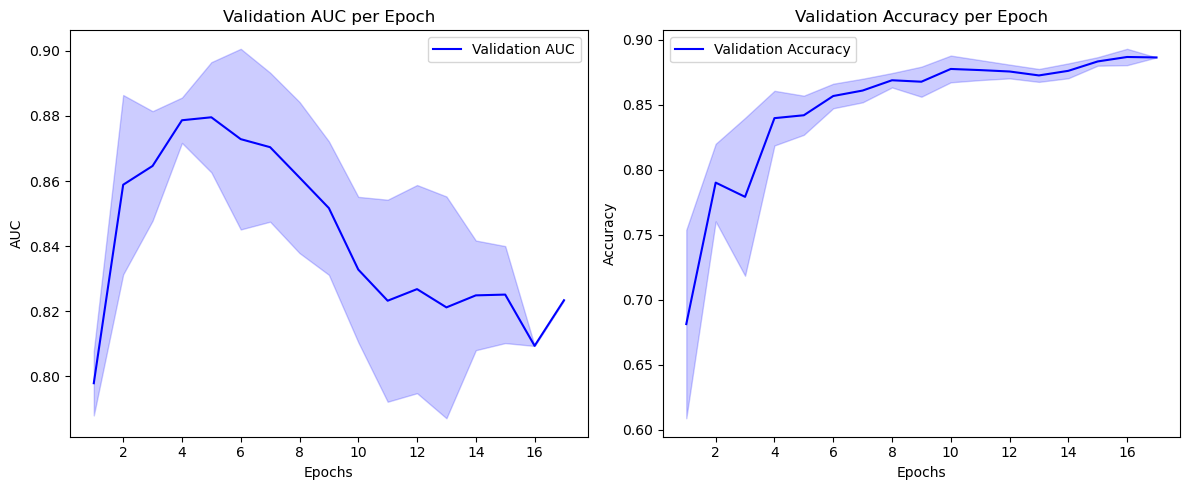

Aggregated Models on holdout set ... 

16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
Holdout ROC AUC: 0.9745
Holdout Accuracy: 0.9164
Holdout MAE: 0.1855
Holdout Percision: 0.6547
Holdout Specificity: 0.9028
Holdout Sensitivity(Recall): 0.9891
Holdout F1: 0.7879 



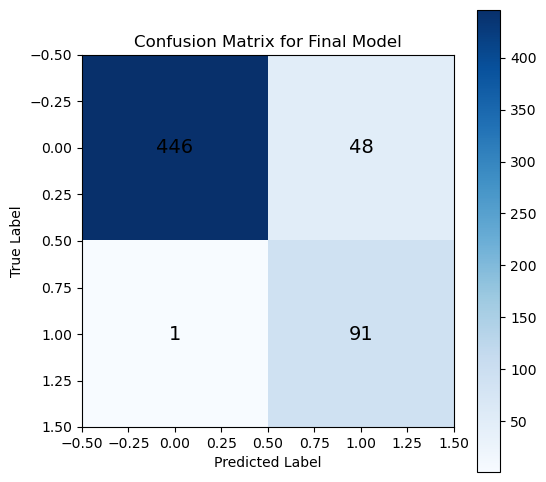


Best 3 models (ROC AUC) to prdict holdout:
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Holdout ROC AUC: 0.9714
Holdout Accuracy: 0.9249
Holdout MAE: 0.1855
Holdout Percision: 0.6791
Holdout Specificity: 0.9130
Holdout Sensitivity(Recall): 0.9891
Holdout F1: 0.8053 



array([[451,  43],
       [  1,  91]])

In [12]:
# Run garbage collection
gc.collect()
################# Smooth 70_Resample&Weights K_Fold 3-channel input w/ Masking, Daily & Individual input, Classifying Hypo Night
########################################################################################################################################
os.environ["CUDA_VISIBLE_DEVICES"] = "3"
folder_name = "/home/ma98/Compressed_DEXI_Data/Hypo_Smooth_Noise/Hypo_Night"
matrix_shape0 = 288
# Reshape matrices to the required shapes
X_features_daily_imputed = np.nan_to_num(X_features_daily_scaled, nan=0.0)
X_features_individual_imputed = np.nan_to_num(X_features_individual_scaled, nan=0.0)

# Create masks for missing values
mask_daily = np.isfinite(X_features_daily_scaled).astype(np.float32)
mask_individual = np.isfinite(X_features_individual_scaled).astype(np.float32)

# Initialize GroupKFold
num_splits = 4
group_kfold = GroupKFold(n_splits=num_splits)
unique_participants = np.unique(participant_ids)
# # Shuffle to ensure no artifacts in test train/validation split
# unique_participants = shuffle(unique_participants, random_state=42)

# Completely hold out a test set before cross-validation
holdout_participants = unique_participants[int(0.95 * len(unique_participants)):]
holdout_idx = np.where(np.isin(participant_ids, holdout_participants))[0]

# Remove the holdout participants from the pool used for cross-validation model
model_participants = unique_participants[:int(0.95 * len(unique_participants))]

final_results_night = {
    "fold_model": [],
    "specificity_scores": [],
    "accuracy_scores": [],
    "precision_scores": [],
    "recall_scores": [],
    "f1_scores": [],
    "roc_auc_scores": [],
    "mae": [],
    "mse": [],
    "fold_train_loss": [],
    "fold_train_auc": [],
    "fold_train_acc": [],
    "fold_val_loss": [],
    "fold_val_auc": [],
    "fold_val_acc": [],
    "conf_matrix": [],
    "class_report": [],
    "train_loss": [],
    "train_acc": [],
    "val_loss": [],
    "val_acc": []
}
for fold, (train_idx, val_test_idx) in enumerate(group_kfold.split(X_matrices_power_scaled, y_labels['hypo_night'], groups=participant_ids)):
    # 75% of the data as train set
    train_participants = model_participants[np.isin(model_participants, participant_ids[train_idx])]    
    val_test_participants = model_participants[np.isin(model_participants, participant_ids[val_test_idx])]
    
    val_size = int(len(val_test_participants) * 3 / 5)
    val_participants = val_test_participants[:val_size]
    test_participants = val_test_participants[val_size:]
    
    # Get corresponding indices
    val_idx = np.where(np.isin(participant_ids, val_participants))[0]
    test_idx = np.where(np.isin(participant_ids, test_participants))[0]
    print(f"Processing fold {fold + 1}...")
    print(f"{len(train_participants)}, {len(val_participants)}, {len(test_participants)}, participants in Train, Validation, and Test sets" )

    # Train-test split based on indices
    X_matrices_coeffs_train,X_matrices_coeffs_val, X_matrices_coeffs_test = X_matrices_power_scaled[train_idx],X_matrices_power_scaled[val_idx], X_matrices_power_scaled[test_idx]
    X_features_daily_train,X_features_daily_val, X_features_daily_test = X_features_daily_imputed[train_idx],X_features_daily_imputed[val_idx], X_features_daily_imputed[test_idx]
    X_features_individual_train,X_features_individual_val, X_features_individual_test = X_features_individual_imputed[train_idx],X_features_individual_imputed[val_idx], X_features_individual_imputed[test_idx]
    y_label_train,y_label_val, y_label_test = y_labels['hypo_night'][train_idx],y_labels['hypo_night'][val_idx], y_labels['hypo_night'][test_idx]
    mask_daily_train,mask_daily_val, mask_daily_test = mask_daily[train_idx], mask_daily[val_idx], mask_daily[test_idx]
    mask_individual_train,mask_individual_val, mask_individual_test = mask_individual[train_idx],mask_individual[val_idx], mask_individual[test_idx]
    X_matrices_coeffs_train_noisy = add_gaussian_noise(X_matrices_coeffs_train)
    X_features_daily_train_noisy = add_gaussian_noise(X_features_daily_train, label='zero_mean')
    X_features_individual_train_noisy = add_gaussian_noise(X_features_individual_train, label='zero_mean')
    # Concatenate original and noisy data for augmentation
    X_matrices_coeffs_train_augmented = np.concatenate([X_matrices_coeffs_train, X_matrices_coeffs_train_noisy], axis=0)
    X_features_daily_train_augmented = np.concatenate([X_features_daily_train, X_features_daily_train_noisy], axis=0)
    X_features_individual_train_augmented = np.concatenate([X_features_individual_train, X_features_individual_train_noisy], axis=0)
    
    # Augment labels and masks (labels and masks remain the same for original and noisy data)
    y_label_train_augmented = np.concatenate([y_label_train, y_label_train], axis=0)
    mask_daily_train_augmented = np.concatenate([mask_daily_train, mask_daily_train], axis=0)
    mask_individual_train_augmented = np.concatenate([mask_individual_train, mask_individual_train], axis=0)

    num_epochs = 50
    # Create a new model instance
    model = create_model()
    early_stopping = EarlyStopping(monitor='val_AUC', patience=4, restore_best_weights=True)
    checkpoint = ModelCheckpoint(filepath=os.path.join(folder_name, 'best_model_fold_{}.keras'.format(fold)), monitor='val_AUC', save_best_only=True, mode='max')
    learning_rate_scheduler = ReduceLROnPlateau(monitor='val_AUC', factor=0.5, patience=2, min_lr=1e-7)
    y_label_train_flat = y_label_train.ravel()
    class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_label_train_flat), y=y_label_train_flat)
    class_weight_dict = dict(enumerate(class_weights))
    print("Class weights: ", class_weight_dict)
    history_hypo_night = model.fit(        
                [X_matrices_coeffs_train_augmented, X_features_daily_train_augmented, X_features_individual_train_augmented, 
                mask_daily_train_augmented, mask_individual_train_augmented], 
                y_label_train_augmented, 
                 epochs=num_epochs, batch_size=16, verbose=1,
                 validation_data=([X_matrices_coeffs_val, X_features_daily_val, X_features_individual_val, mask_daily_val, mask_individual_val], y_label_val),
                 callbacks=[early_stopping, learning_rate_scheduler, checkpoint],
                 class_weight=class_weight_dict)
    # Evaluate training and testing performance
    train_score = model.evaluate([X_matrices_coeffs_train, X_features_daily_train, X_features_individual_train, mask_daily_train, mask_individual_train], 
                                 y_label_train, verbose=0)
    val_score = model.evaluate([X_matrices_coeffs_val, X_features_daily_val, X_features_individual_val, mask_daily_val, mask_individual_val], 
                                y_label_val, verbose=0)
    print('\nTrain loss: {}, Train accuracy: {}'.format(train_score[0], train_score[1]))
    print('Validation loss: {}, Validation accuracy: {}'.format(val_score[0], val_score[1]))
    # print('Test loss: {}, Test accuracy: {}\n'.format(test_score[0], test_score[1]))
    y_pred_train = model.predict([X_matrices_coeffs_train, X_features_daily_train,X_features_individual_train, mask_daily_train, mask_individual_train])
    y_pred_test = model.predict([X_matrices_coeffs_test, X_features_daily_test,X_features_individual_test, mask_daily_test, mask_individual_test])

    mae_train = mean_absolute_error(y_label_train, y_pred_train)
    mse_train = mean_squared_error(y_label_train, y_pred_train)

    roc_auc_test = roc_auc_score(y_label_test, y_pred_test)
    print(f'Test ROC AUC: {roc_auc_test:.4f}')

    y_pred_train_binary = (y_pred_train >= 0.5).astype(int)
    y_pred_test_binary = (y_pred_test >= 0.4).astype(int)
    mae_test = mean_absolute_error(y_label_test, y_pred_test)
    mse_test = mean_squared_error(y_label_test, y_pred_test)
    accuracy = accuracy_score(y_label_test, y_pred_test_binary)
    recall = recall_score(y_label_test, y_pred_test_binary)
    f1 = f1_score(y_label_test, y_pred_test_binary)
    precision = precision_score(y_label_test, y_pred_test_binary)
    specificity = recall_score(y_label_test, y_pred_test_binary, pos_label=0)
    print(f'Test Accuracy: {accuracy:.4f}')
    print(f'Test MAE: {mae_test:.4f}')
    print(f'Test Percision: {precision:.4f}')
    print(f'Test Specificity: {specificity:.4f}')
    print(f'Test Sensitivity(Recall): {recall:.4f}')
    print(f'Test F1: {f1:.4f} \n')
    print(f'Fold {fold + 1} - AUC: {roc_auc_test:.4f}, Accuracy: {accuracy:.4f}, Recall: {recall:.4f}, Precision: {precision:.4f}, Specificity: {specificity:.4f}, F1: {f1:.4f}\n')

    # Confusion Matrix
    conf_matrix = confusion_matrix(y_label_test, y_pred_test_binary)
    # Classification Report
    class_report = classification_report(y_label_test, y_pred_test_binary)
    print(conf_matrix)
    final_results_night["precision_scores"].append(precision)
    final_results_night["recall_scores"].append(recall)
    final_results_night["f1_scores"].append(f1)
    final_results_night["accuracy_scores"].append(accuracy)
    final_results_night["roc_auc_scores"].append(roc_auc_test)
    final_results_night["specificity_scores"].append(specificity)
    final_results_night["mae"].append(mae_test)
    final_results_night["mse"].append(mse_test)
    final_results_night["train_loss"].append(train_score[0])
    final_results_night["train_acc"].append(train_score[1])
    final_results_night["val_loss"].append(val_score[0])
    final_results_night["val_acc"].append(val_score[1])
    final_results_night["fold_train_acc"].append(history_hypo_night.history['accuracy'])
    final_results_night["fold_train_loss"].append(history_hypo_night.history['loss'])
    final_results_night["fold_train_auc"].append(history_hypo_night.history['AUC'])
    final_results_night["fold_val_acc"].append(history_hypo_night.history['val_accuracy'])
    final_results_night["fold_val_loss"].append(history_hypo_night.history['val_loss'])
    final_results_night["fold_val_auc"].append(history_hypo_night.history['val_AUC'])
    final_results_night["conf_matrix"].append(conf_matrix)
    final_results_night["class_report"].append(class_report)
    final_results_night["fold_model"].append(model)
          
# Calculate and print average and std across folds
print(f'\nAverage Train Accuracy: {np.mean(final_results_night["train_acc"]):.4f} (+- {np.std(final_results_night["train_acc"]):.4f})')
print(f'Average Validation Accuracy: {np.mean(final_results_night["val_acc"]):.4f} (+- {np.std(final_results_night["val_acc"]):.4f})')
print(f'Average Test Accuracy: {np.mean(final_results_night["accuracy_scores"]):.4f} (+- {np.std(final_results_night["accuracy_scores"]):.4f})')
print(f'Average Test Recall: {np.mean(final_results_night["recall_scores"]):.4f} (+- {np.std(final_results_night["recall_scores"]):.4f})')
print(f'Average Test Precision: {np.mean(final_results_night["precision_scores"]):.4f} (+- {np.std(final_results_night["precision_scores"]):.4f})')
print(f'Average Test Specificity: {np.mean(final_results_night["specificity_scores"]):.4f} (+- {np.std(final_results_night["specificity_scores"]):.4f})')
print(f'Average Test AUC: {np.mean(final_results_night["roc_auc_scores"]):.4f} (+- {np.std(final_results_night["roc_auc_scores"]):.4f})')
print(f'Average Test F1: {np.mean(final_results_night["f1_scores"]):.4f} (+- {np.std(final_results_night["f1_scores"]):.4f})')

max_epochs = max(len(fold) for fold in final_results_night["fold_val_loss"])
# Initialize arrays to store average and std dev for each epoch
avg_auc = np.zeros(max_epochs)
std_auc = np.zeros(max_epochs)
avg_acc = np.zeros(max_epochs)
std_acc = np.zeros(max_epochs)
# Compute average and standard deviation for each epoch
for epoch in range(max_epochs):
    aucs = []
    accuracies = []
    for fold_auc, fold_acc in zip(final_results_night["fold_val_auc"], final_results_night["fold_val_acc"]):
        if epoch < len(fold_auc):
            aucs.append(fold_auc[epoch])
        if epoch < len(fold_acc):
            accuracies.append(fold_acc[epoch])
    
    if aucs:
        avg_auc[epoch] = np.mean(aucs)
        std_auc[epoch] = np.std(aucs)
    if accuracies:
        avg_acc[epoch] = np.mean(accuracies)
        std_acc[epoch] = np.std(accuracies)
# Plot average loss and accuracy
plt.figure(figsize=(12, 5))
# Loss plot
plt.subplot(1, 2, 1)
plt.plot(range(1, max_epochs + 1), avg_auc, color='blue', label='Validation AUC')
plt.fill_between(range(1, max_epochs + 1), 
                 avg_auc - std_auc,
                 avg_auc + std_auc,
                 color='blue', alpha=0.2)
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.title('Validation AUC per Epoch')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(range(1, max_epochs + 1), avg_acc, color='blue', label='Validation Accuracy')
plt.fill_between(range(1, max_epochs + 1), 
                 avg_acc - std_acc,
                 avg_acc + std_acc,
                 color='blue', alpha=0.2)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy per Epoch')
plt.legend()

plt.tight_layout()
plt.savefig(os.path.join(folder_name, 'auc_accuracy_plot.png'))
plt.show()

########################################################################################################################################
print(f"Aggregated Models on holdout set ... \n")

# Train-test split based on indices
X_matrices_coeffs_holdout = X_matrices_power_scaled[holdout_idx]
X_features_daily_holdout = X_features_daily_imputed[holdout_idx]
X_features_individual_holdout = X_features_individual_imputed[holdout_idx]
y_label_holdout = y_labels['hypo_night'][holdout_idx]
mask_daily_holdout = mask_daily[holdout_idx]
mask_individual_holdout = mask_individual[holdout_idx]

# Initialize arrays to store predictions from each fold
y_pred_holdout_agg = np.zeros((len(holdout_idx),))  # Assuming binary classification
# Aggregate predictions from each fold model
for model in final_results_night["fold_model"]:
    y_pred_holdout_fold = model.predict([X_matrices_coeffs_holdout, X_features_daily_holdout, X_features_individual_holdout, mask_daily_holdout, mask_individual_holdout])
    y_pred_holdout_agg += y_pred_holdout_fold.flatten()  # Accumulate predictions
    y_pred_holdout_avg = np.mean(y_pred_holdout_fold, axis=0)
# Average the predictions from all folds
y_pred_holdout_agg /= num_splits

mae_holdout = mean_absolute_error(y_label_holdout, y_pred_holdout_agg)
mse_holdout = mean_squared_error(y_label_holdout, y_pred_holdout_agg)
roc_auc = roc_auc_score(y_label_holdout, y_pred_holdout_agg)
print(f'Holdout ROC AUC: {roc_auc:.4f}')

y_pred_holdout_binary_agg = (y_pred_holdout_agg >= 0.5).astype(int)
accuracy = accuracy_score(y_label_holdout, y_pred_holdout_binary_agg)
recall = recall_score(y_label_holdout, y_pred_holdout_binary_agg)
precision = precision_score(y_label_holdout, y_pred_holdout_binary_agg)
f1 = f1_score(y_label_holdout, y_pred_holdout_binary_agg)
specificity = recall_score(y_label_holdout, y_pred_holdout_binary_agg, pos_label=0)

print(f'Holdout Accuracy: {accuracy:.4f}')
print(f'Holdout MAE: {mae_test:.4f}')
print(f'Holdout Percision: {precision:.4f}')
print(f'Holdout Specificity: {specificity:.4f}')
print(f'Holdout Sensitivity(Recall): {recall:.4f}')
print(f'Holdout F1: {f1:.4f} \n')

# Confusion Matrix
conf_matrix = confusion_matrix(y_label_holdout, y_pred_holdout_binary_agg)
plt.figure(figsize=(6, 6))
plt.imshow(conf_matrix, cmap='Blues', interpolation='nearest')
plt.title('Confusion Matrix for Final Model')
plt.colorbar()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Add text annotations
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, conf_matrix[i, j], 
                 ha='center', va='center', color='black', fontsize=14)
plt.savefig(os.path.join(folder_name, 'conf_matrix_plot.png'))
plt.show()

description_path = os.path.join(folder_name, 'Description.txt')
with open(description_path, 'w') as f:
    f.write("""
    # K_Fold 3-channel _ORIGINAL _Below70 Hypo, input w/ Masking, Daily & Individual input, Classifying Hypo Night
    """)
        # Write the results
    f.write(f'\nAverage Train Accuracy: {np.mean(final_results_night["train_acc"]):.4f} (+- {np.std(final_results_night["train_acc"]):.4f})\n')
    f.write(f'Average Validation Accuracy: {np.mean(final_results_night["val_acc"]):.4f} (+- {np.std(final_results_night["val_acc"]):.4f})\n')
    f.write(f'Average Test Accuracy: {np.mean(final_results_night["accuracy_scores"]):.4f} (+- {np.std(final_results_night["accuracy_scores"]):.4f})\n')
    f.write(f'Average Test Recall: {np.mean(final_results_night["recall_scores"]):.4f} (+- {np.std(final_results_night["recall_scores"]):.4f})\n')
    f.write(f'Average Test Precision: {np.mean(final_results_night["precision_scores"]):.4f} (+- {np.std(final_results_night["precision_scores"]):.4f})\n')
    f.write(f'Average Test Specificity: {np.mean(final_results_night["specificity_scores"]):.4f} (+- {np.std(final_results_night["specificity_scores"]):.4f})\n')
    f.write(f'Average Test AUC: {np.mean(final_results_night["roc_auc_scores"]):.4f} (+- {np.std(final_results_night["roc_auc_scores"]):.4f})\n')
    f.write(f'Average Test F1: {np.mean(final_results_night["f1_scores"]):.4f} (+- {np.std(final_results_night["f1_scores"]):.4f})\n')
    
    # Writing holdout results
    f.write(f'Holdout ROC AUC: {roc_auc:.4f}\n')
    f.write(f'Holdout Accuracy: {accuracy:.4f}\n')
    f.write(f'Holdout MAE: {mae_test:.4f}\n')
    f.write(f'Holdout Precision: {precision:.4f}\n')
    f.write(f'Holdout Specificity: {specificity:.4f}\n')
    f.write(f'Holdout Sensitivity (Recall): {recall:.4f}\n')
    f.write(f'Holdout F1: {f1:.4f}\n')
model_summary_path = os.path.join(folder_name, 'model_summary.txt')
with open(model_summary_path, 'w') as f:
    model.summary(print_fn=lambda x: f.write(x + '\n'))
#model.summary()
# Save the final results as pickle
final_results_path = os.path.join(folder_name, 'final_results.pkl')
with open(final_results_path, 'wb') as file:
    pickle.dump(final_results_night, file)

print("\nBest 3 models (ROC AUC) to prdict holdout:")
best_of = 3
top_3_model_indices = np.argsort(final_results_night["roc_auc_scores"])[-best_of:][::-1]
y_pred_holdout_agg = np.zeros((len(holdout_idx),))  # Assuming binary classification
for idx in top_3_model_indices:
    model = final_results_night["fold_model"][idx]
    y_pred_holdout_fold = model.predict([X_matrices_coeffs_holdout, X_features_daily_holdout, X_features_individual_holdout, mask_daily_holdout, mask_individual_holdout])
    y_pred_holdout_agg += y_pred_holdout_fold.flatten()
y_pred_holdout_agg /= best_of

mae_holdout = mean_absolute_error(y_label_holdout, y_pred_holdout_agg)
mse_holdout = mean_squared_error(y_label_holdout, y_pred_holdout_agg)
roc_auc = roc_auc_score(y_label_holdout, y_pred_holdout_agg)
print(f'Holdout ROC AUC: {roc_auc:.4f}')

y_pred_holdout_binary_agg = (y_pred_holdout_agg >= 0.5).astype(int)
accuracy = accuracy_score(y_label_holdout, y_pred_holdout_binary_agg)
recall = recall_score(y_label_holdout, y_pred_holdout_binary_agg)
precision = precision_score(y_label_holdout, y_pred_holdout_binary_agg)
f1 = f1_score(y_label_holdout, y_pred_holdout_binary_agg)
specificity = recall_score(y_label_holdout, y_pred_holdout_binary_agg, pos_label=0)

print(f'Holdout Accuracy: {accuracy:.4f}')
print(f'Holdout MAE: {mae_test:.4f}')
print(f'Holdout Percision: {precision:.4f}')
print(f'Holdout Specificity: {specificity:.4f}')
print(f'Holdout Sensitivity(Recall): {recall:.4f}')
print(f'Holdout F1: {f1:.4f} \n')
conf_matrix = confusion_matrix(y_label_holdout, y_pred_holdout_binary_agg)
conf_matrix


Processing fold 1...
351, 69, 46, participants in Train, Validation, and Test sets


2024-10-08 12:48:29.457373: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 78973 MB memory:  -> device: 3, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:57:00.0, compute capability: 8.0
2024-10-08 12:48:30.935185: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-10-08 12:48:30.935216: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-10-08 12:48:30.935253: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is k

Class weights:  {0: 0.5849001603264831, 1: 3.4446351931330472}
Epoch 1/50


2024-10-08 12:59:15.088558: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f9bd00081b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-10-08 12:59:15.088650: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A100-SXM4-80GB, Compute Capability 8.0
2024-10-08 12:59:15.521740: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-08 12:59:17.837339: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8907
2024-10-08 12:59:20.377685: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-10-08 12:59:20.381447: W tensorflow/compiler/xla/stream_executor/gpu/re

1002/1004 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - AUC: 0.5171 - accuracy: 0.4560 - loss: 2.2532



2024-10-08 12:59:44.258246: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



1004/1004 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - AUC: 0.5171 - accuracy: 0.4559 - loss: 2.2521



2024-10-08 13:00:27.238168: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



1004/1004 ━━━━━━━━━━━━━━━━━━━━ 95s 78ms/step - AUC: 0.5171 - accuracy: 0.4559 - loss: 2.2515 - val_AUC: 0.4998 - val_accuracy: 0.8682 - val_loss: 1.0680 - learning_rate: 5.0000e-05
Epoch 2/50
1004/1004 ━━━━━━━━━━━━━━━━━━━━ 17s 17ms/step - AUC: 0.6162 - accuracy: 0.5067 - loss: 1.0063 - val_AUC: 0.7920 - val_accuracy: 0.7215 - val_loss: 0.9360 - learning_rate: 5.0000e-05
Epoch 3/50
1004/1004 ━━━━━━━━━━━━━━━━━━━━ 20s 20ms/step - AUC: 0.8282 - accuracy: 0.7181 - loss: 0.7856 - val_AUC: 0.8581 - val_accuracy: 0.7911 - val_loss: 0.6594 - learning_rate: 5.0000e-05
Epoch 4/50
1004/1004 ━━━━━━━━━━━━━━━━━━━━ 23s 22ms/step - AUC: 0.8995 - accuracy: 0.8235 - loss: 0.5947 - val_AUC: 0.8757 - val_accuracy: 0.7989 - val_loss: 0.5760 - learning_rate: 5.0000e-05
Epoch 5/50
1004/1004 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - AUC: 0.9336 - accuracy: 0.8573 - loss: 0.4869 - val_AUC: 0.8658 - val_accuracy: 0.8224 - val_loss: 0.5288 - learning_rate: 5.0000e-05
Epoch 6/50
1004/1004 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/



2024-10-08 13:10:58.608393: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



2024-10-08 13:11:05.782283: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.




Train loss: 0.5389460921287537, Train accuracy: 0.8234487771987915
Validation loss: 0.5760586857795715, Validation accuracy: 0.79857337474823




2024-10-08 13:17:12.317700: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



501/502 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step



2024-10-08 13:17:20.028270: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



502/502 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step
60/64 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step



2024-10-08 13:17:43.416166: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
Test ROC AUC: 0.8794
Test Accuracy: 0.7421
Test MAE: 0.2665
Test Percision: 0.3352
Test Specificity: 0.7207
Test Sensitivity(Recall): 0.8750
Test F1: 0.4847 

Fold 1 - AUC: 0.8794, Accuracy: 0.7421, Recall: 0.8750, Precision: 0.3352, Specificity: 0.7207, F1: 0.4847

[[1254  486]
 [  35  245]]
Processing fold 2...
349, 70, 47, participants in Train, Validation, and Test sets
Class weights:  {0: 0.580752532561505, 1: 3.595878136200717}
Epoch 1/50




2024-10-08 13:25:07.057475: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



1002/1004 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - AUC: 0.6074 - accuracy: 0.6767 - loss: 2.2500



2024-10-08 13:25:27.074113: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



1004/1004 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - AUC: 0.6076 - accuracy: 0.6766 - loss: 2.2490



2024-10-08 13:25:35.420159: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



2024-10-08 13:25:37.675587: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



1004/1004 ━━━━━━━━━━━━━━━━━━━━ 45s 33ms/step - AUC: 0.6077 - accuracy: 0.6766 - loss: 2.2485 - val_AUC: 0.7934 - val_accuracy: 0.7121 - val_loss: 1.0619 - learning_rate: 5.0000e-05
Epoch 2/50
1004/1004 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - AUC: 0.8099 - accuracy: 0.7154 - loss: 1.0642 - val_AUC: 0.8180 - val_accuracy: 0.7226 - val_loss: 0.8261 - learning_rate: 5.0000e-05
Epoch 3/50
1004/1004 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - AUC: 0.8681 - accuracy: 0.7601 - loss: 0.7615 - val_AUC: 0.8569 - val_accuracy: 0.8097 - val_loss: 0.6984 - learning_rate: 5.0000e-05
Epoch 4/50
1004/1004 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - AUC: 0.9186 - accuracy: 0.8277 - loss: 0.6122 - val_AUC: 0.8568 - val_accuracy: 0.8176 - val_loss: 0.6397 - learning_rate: 5.0000e-05
Epoch 5/50
1004/1004 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - AUC: 0.9400 - accuracy: 0.8555 - loss: 0.5212 - val_AUC: 0.8658 - val_accuracy: 0.8202 - val_loss: 0.6349 - learning_rate: 5.0000e-05
Epoch 6/50
1004/1004 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/







2024-10-08 13:32:19.205270: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.




Train loss: 0.37639597058296204, Train accuracy: 0.9212559461593628
Validation loss: 0.6005514860153198, Validation accuracy: 0.8475848436355591


499/502 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

502/502 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step
61/65 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step



2024-10-08 13:35:17.458621: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
Test ROC AUC: 0.8528
Test Accuracy: 0.8165
Test MAE: 0.1870
Test Percision: 0.4726
Test Specificity: 0.8474
Test Sensitivity(Recall): 0.6657
Test F1: 0.5528 

Fold 2 - AUC: 0.8528, Accuracy: 0.8165, Recall: 0.6657, Precision: 0.4726, Specificity: 0.8474, F1: 0.5528

[[1444  260]
 [ 117  233]]
Processing fold 3...
349, 70, 47, participants in Train, Validation, and Test sets
Class weights:  {0: 0.579399451421972, 1: 3.6486363636363635}
Epoch 1/50




2024-10-08 13:43:45.780107: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



1003/1004 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - AUC: 0.6305 - accuracy: 0.7744 - loss: 2.3678



2024-10-08 13:44:08.362996: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



1004/1004 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - AUC: 0.6306 - accuracy: 0.7744 - loss: 2.3673





2024-10-08 13:45:29.543326: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



1004/1004 ━━━━━━━━━━━━━━━━━━━━ 118s 106ms/step - AUC: 0.6306 - accuracy: 0.7743 - loss: 2.3669 - val_AUC: 0.7551 - val_accuracy: 0.7575 - val_loss: 1.1845 - learning_rate: 5.0000e-05
Epoch 2/50
1004/1004 ━━━━━━━━━━━━━━━━━━━━ 17s 17ms/step - AUC: 0.8163 - accuracy: 0.7269 - loss: 1.1428 - val_AUC: 0.8108 - val_accuracy: 0.7495 - val_loss: 0.8503 - learning_rate: 5.0000e-05
Epoch 3/50
1004/1004 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - AUC: 0.8713 - accuracy: 0.7811 - loss: 0.8185 - val_AUC: 0.8443 - val_accuracy: 0.7243 - val_loss: 0.8423 - learning_rate: 5.0000e-05
Epoch 4/50
1004/1004 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - AUC: 0.9192 - accuracy: 0.8336 - loss: 0.6296 - val_AUC: 0.8482 - val_accuracy: 0.8080 - val_loss: 0.6976 - learning_rate: 5.0000e-05
Epoch 5/50
1004/1004 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - AUC: 0.9382 - accuracy: 0.8624 - loss: 0.5401 - val_AUC: 0.8394 - val_accuracy: 0.8419 - val_loss: 0.6548 - learning_rate: 5.0000e-05
Epoch 6/50
1004/1004 ━━━━━━━━━━━━━━━━━━━━ 14s 14m





2024-10-08 13:53:02.818384: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.




Train loss: 0.5886239409446716, Train accuracy: 0.8511274456977844
Validation loss: 0.697655439376831, Validation accuracy: 0.8079734444618225


497/502 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step



2024-10-08 14:02:59.486265: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



502/502 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step
61/65 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step



2024-10-08 14:03:49.116704: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step
Test ROC AUC: 0.8575
Test Accuracy: 0.7898
Test MAE: 0.2276
Test Percision: 0.3993
Test Specificity: 0.7932
Test Sensitivity(Recall): 0.7707
Test F1: 0.5261 

Fold 3 - AUC: 0.8575, Accuracy: 0.7898, Recall: 0.7707, Precision: 0.3993, Specificity: 0.7932, F1: 0.5261

[[1396  364]
 [  72  242]]
Processing fold 4...
349, 70, 47, participants in Train, Validation, and Test sets
Class weights:  {0: 0.5804888631761643, 1: 3.6060197663971247}
Epoch 1/50


1001/1004 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - AUC: 0.6542 - accuracy: 0.7099 - loss: 2.1321



2024-10-08 14:11:27.524400: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



1004/1004 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - AUC: 0.6543 - accuracy: 0.7098 - loss: 2.1303

1004/1004 ━━━━━━━━━━━━━━━━━━━━ 59s 48ms/step - AUC: 0.6544 - accuracy: 0.7097 - loss: 2.1297 - val_AUC: 0.7632 - val_accuracy: 0.7052 - val_loss: 0.8339 - learning_rate: 5.0000e-05
Epoch 2/50
1004/1004 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - AUC: 0.8252 - accuracy: 0.7393 - loss: 0.8516 - val_AUC: 0.8035 - val_accuracy: 0.7379 - val_loss: 0.7076 - learning_rate: 5.0000e-05
Epoch 3/50
1004/1004 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - AUC: 0.8743 - accuracy: 0.7875 - loss: 0.6980 - val_AUC: 0.8278 - val_accuracy: 0.7382 - val_loss: 0.7787 - learning_rate: 5.0000e-05
Epoch 4/50
1004/1004 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - AUC: 0.9241 - accuracy: 0.8357 - loss: 0.5606 - val_AUC: 0.8319 - val_accuracy: 0.7961 - val_loss: 0.6755 - learning_rate: 5.0000e-05
Epoch 5/50
1004/1004 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - AUC: 0.9433 - accuracy: 0.8653 - loss: 0.4998 - val_AUC: 0.8384 - val_accuracy: 0.8123 - val_loss: 0.6493 - learning_rate: 5.0000e-05
Epoch 6/50
1004/1004 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/


Train loss: 0.49816691875457764, Train accuracy: 0.8774137496948242
Validation loss: 0.6492472290992737, Validation accuracy: 0.8123409748077393


497/502 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

502/502 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step
56/61 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step



2024-10-08 14:21:39.800134: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
Test ROC AUC: 0.8626
Test Accuracy: 0.8018
Test MAE: 0.2049
Test Percision: 0.4379
Test Specificity: 0.8169
Test Sensitivity(Recall): 0.7247
Test F1: 0.5459 

Fold 4 - AUC: 0.8626, Accuracy: 0.8018, Recall: 0.7247, Precision: 0.4379, Specificity: 0.8169, F1: 0.5459

[[1312  294]
 [  87  229]]

Average Train Accuracy: 0.8683 (+- 0.0360)
Average Validation Accuracy: 0.8166 (+- 0.0186)
Average Test Accuracy: 0.7875 (+- 0.0279)
Average Test Recall: 0.7590 (+- 0.0766)
Average Test Precision: 0.4112 (+- 0.0510)
Average Test Specificity: 0.7946 (+- 0.0468)
Average Test AUC: 0.8631 (+- 0.0100)
Average Test F1: 0.5274 (+- 0.0265)


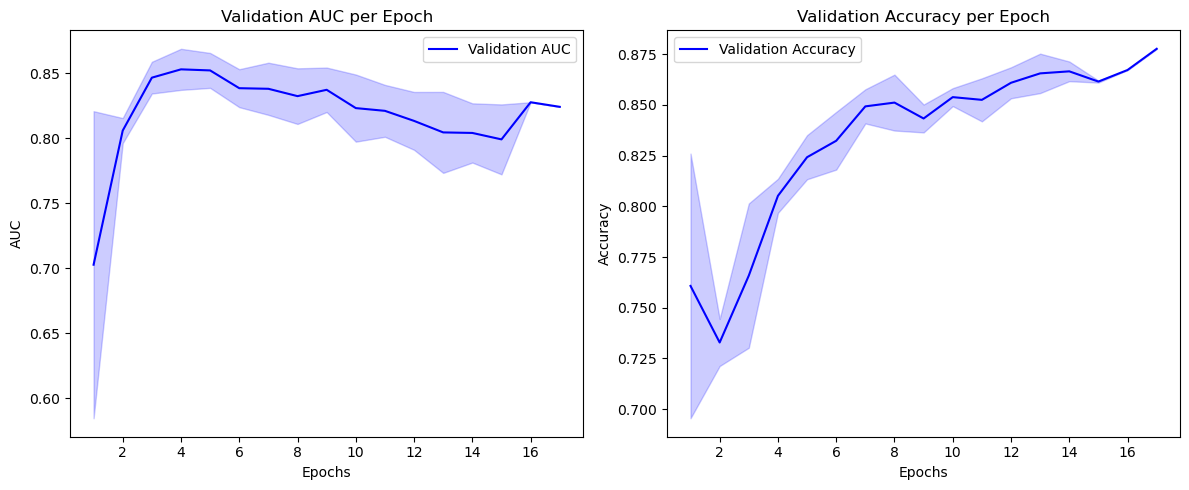

Aggregated Models on holdout set ... 

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
36/37 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
31/37 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
Holdout ROC AUC: 0.9645
Holdout Accuracy: 0.8874
Holdout MAE: 0.2049
Holdout Percision: 0.5878
Holdout Specificity: 0.8765
Holdout Sensitivity(Recall): 0.9457
Holdout F1: 0.7250 



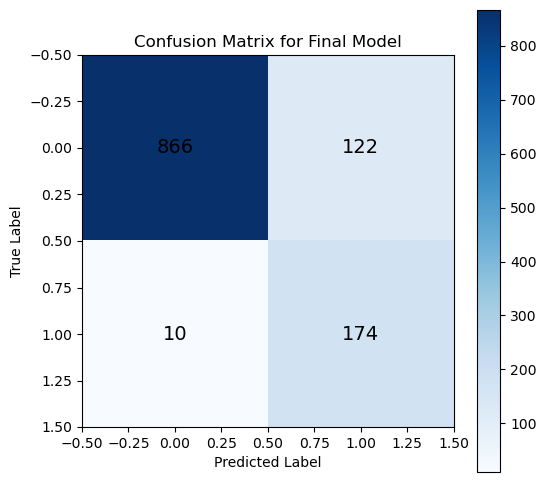


Best 3 models (ROC AUC) to prdict holdout:
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Holdout ROC AUC: 0.9484
Holdout Accuracy: 0.8601
Holdout MAE: 0.2049
Holdout Percision: 0.5316
Holdout Specificity: 0.8502
Holdout Sensitivity(Recall): 0.9130
Holdout F1: 0.6720 



array([[840, 148],
       [ 16, 168]])

In [10]:
# Run garbage collection
gc.collect()
################# Smooth 70_Resample&Weights K_Fold 3-channel input w/ Masking, Daily & Individual input, Classifying Hypo Night
########################################################################################################################################
os.environ["CUDA_VISIBLE_DEVICES"] = "3"
folder_name = "/home/ma98/Compressed_DEXI_Data/Hypo_Smooth_Noise/Hypo_Night"
matrix_shape0 = 288

# Initialize GroupKFold
num_splits = 4
group_kfold = GroupKFold(n_splits=num_splits)
unique_participants = np.unique(participant_ids)
# # Shuffle to ensure no artifacts in test train/validation split
# unique_participants = shuffle(unique_participants, random_state=42)

# Completely hold out a test set before cross-validation
holdout_participants = unique_participants[int(0.95 * len(unique_participants)):]
holdout_idx = np.where(np.isin(participant_ids, holdout_participants))[0]

# Remove the holdout participants from the pool used for cross-validation model
model_participants = unique_participants[:int(0.95 * len(unique_participants))]

final_results_night = {
    "fold_model": [],
    "specificity_scores": [],
    "accuracy_scores": [],
    "precision_scores": [],
    "recall_scores": [],
    "f1_scores": [],
    "roc_auc_scores": [],
    "mae": [],
    "mse": [],
    "fold_train_loss": [],
    "fold_train_auc": [],
    "fold_train_acc": [],
    "fold_val_loss": [],
    "fold_val_auc": [],
    "fold_val_acc": [],
    "conf_matrix": [],
    "class_report": [],
    "train_loss": [],
    "train_acc": [],
    "val_loss": [],
    "val_acc": []
}
for fold, (train_idx, val_test_idx) in enumerate(group_kfold.split(X_matrices_power_scaled, y_labels['hypo_night'], groups=participant_ids)):
    # 75% of the data as train set
    train_participants = model_participants[np.isin(model_participants, participant_ids[train_idx])]    
    val_test_participants = model_participants[np.isin(model_participants, participant_ids[val_test_idx])]
    
    val_size = int(len(val_test_participants) * 3 / 5)
    val_participants = val_test_participants[:val_size]
    test_participants = val_test_participants[val_size:]
    
    # Get corresponding indices
    val_idx = np.where(np.isin(participant_ids, val_participants))[0]
    test_idx = np.where(np.isin(participant_ids, test_participants))[0]
    print(f"Processing fold {fold + 1}...")
    print(f"{len(train_participants)}, {len(val_participants)}, {len(test_participants)}, participants in Train, Validation, and Test sets" )

    # Train-test split based on indices
    X_matrices_coeffs_train,X_matrices_coeffs_val, X_matrices_coeffs_test = X_matrices_power_scaled[train_idx],X_matrices_power_scaled[val_idx], X_matrices_power_scaled[test_idx]
    X_features_daily_train,X_features_daily_val, X_features_daily_test = X_features_daily_imputed[train_idx],X_features_daily_imputed[val_idx], X_features_daily_imputed[test_idx]
    X_features_individual_train,X_features_individual_val, X_features_individual_test = X_features_individual_imputed[train_idx],X_features_individual_imputed[val_idx], X_features_individual_imputed[test_idx]
    y_label_train,y_label_val, y_label_test = y_labels['hypo_night'][train_idx],y_labels['hypo_night'][val_idx], y_labels['hypo_night'][test_idx]
    mask_daily_train,mask_daily_val, mask_daily_test = mask_daily[train_idx], mask_daily[val_idx], mask_daily[test_idx]
    mask_individual_train,mask_individual_val, mask_individual_test = mask_individual[train_idx],mask_individual[val_idx], mask_individual[test_idx]
    num_epochs = 50
    # Create a new model instance
    model = create_model()
    early_stopping = EarlyStopping(monitor='val_AUC', patience=10, restore_best_weights=True)
    checkpoint = ModelCheckpoint(filepath=os.path.join(folder_name, 'best_model_fold_{}.keras'.format(fold)), monitor='val_AUC', save_best_only=True, mode='max')
    learning_rate_scheduler = ReduceLROnPlateau(monitor='val_AUC', factor=0.5, patience=5, min_lr=1e-7)
    y_label_train_flat = y_label_train.ravel()
    class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_label_train_flat), y=y_label_train_flat)
    class_weight_dict = dict(enumerate(class_weights))
    print("Class weights: ", class_weight_dict)
    history_hypo_night = model.fit([X_matrices_coeffs_train, X_features_daily_train, X_features_individual_train, mask_daily_train, mask_individual_train], 
                                         y_label_train, 
                                         epochs=num_epochs, batch_size=16, verbose=1,
                                         validation_data=([X_matrices_coeffs_val, X_features_daily_val, X_features_individual_val, mask_daily_val, mask_individual_val], y_label_val),
                                         callbacks=[early_stopping, learning_rate_scheduler, checkpoint],
                                         class_weight=class_weight_dict)
    # Evaluate training and testing performance
    train_score = model.evaluate([X_matrices_coeffs_train, X_features_daily_train, X_features_individual_train, mask_daily_train, mask_individual_train], 
                                 y_label_train, verbose=0)
    val_score = model.evaluate([X_matrices_coeffs_val, X_features_daily_val, X_features_individual_val, mask_daily_val, mask_individual_val], 
                                y_label_val, verbose=0)
    print('\nTrain loss: {}, Train accuracy: {}'.format(train_score[0], train_score[1]))
    print('Validation loss: {}, Validation accuracy: {}'.format(val_score[0], val_score[1]))
    # print('Test loss: {}, Test accuracy: {}\n'.format(test_score[0], test_score[1]))
    y_pred_train = model.predict([X_matrices_coeffs_train, X_features_daily_train,X_features_individual_train, mask_daily_train, mask_individual_train])
    y_pred_test = model.predict([X_matrices_coeffs_test, X_features_daily_test,X_features_individual_test, mask_daily_test, mask_individual_test])

    mae_train = mean_absolute_error(y_label_train, y_pred_train)
    mse_train = mean_squared_error(y_label_train, y_pred_train)

    roc_auc_test = roc_auc_score(y_label_test, y_pred_test)
    print(f'Test ROC AUC: {roc_auc_test:.4f}')

    y_pred_train_binary = (y_pred_train >= 0.5).astype(int)
    y_pred_test_binary = (y_pred_test >= 0.4).astype(int)
    mae_test = mean_absolute_error(y_label_test, y_pred_test)
    mse_test = mean_squared_error(y_label_test, y_pred_test)
    accuracy = accuracy_score(y_label_test, y_pred_test_binary)
    recall = recall_score(y_label_test, y_pred_test_binary)
    f1 = f1_score(y_label_test, y_pred_test_binary)
    precision = precision_score(y_label_test, y_pred_test_binary)
    specificity = recall_score(y_label_test, y_pred_test_binary, pos_label=0)
    print(f'Test Accuracy: {accuracy:.4f}')
    print(f'Test MAE: {mae_test:.4f}')
    print(f'Test Percision: {precision:.4f}')
    print(f'Test Specificity: {specificity:.4f}')
    print(f'Test Sensitivity(Recall): {recall:.4f}')
    print(f'Test F1: {f1:.4f} \n')
    print(f'Fold {fold + 1} - AUC: {roc_auc_test:.4f}, Accuracy: {accuracy:.4f}, Recall: {recall:.4f}, Precision: {precision:.4f}, Specificity: {specificity:.4f}, F1: {f1:.4f}\n')

    # Confusion Matrix
    conf_matrix = confusion_matrix(y_label_test, y_pred_test_binary)
    # Classification Report
    class_report = classification_report(y_label_test, y_pred_test_binary)
    print(conf_matrix)
    final_results_night["precision_scores"].append(precision)
    final_results_night["recall_scores"].append(recall)
    final_results_night["f1_scores"].append(f1)
    final_results_night["accuracy_scores"].append(accuracy)
    final_results_night["roc_auc_scores"].append(roc_auc_test)
    final_results_night["specificity_scores"].append(specificity)
    final_results_night["mae"].append(mae_test)
    final_results_night["mse"].append(mse_test)
    final_results_night["train_loss"].append(train_score[0])
    final_results_night["train_acc"].append(train_score[1])
    final_results_night["val_loss"].append(val_score[0])
    final_results_night["val_acc"].append(val_score[1])
    final_results_night["fold_train_acc"].append(history_hypo_night.history['accuracy'])
    final_results_night["fold_train_loss"].append(history_hypo_night.history['loss'])
    final_results_night["fold_train_auc"].append(history_hypo_night.history['AUC'])
    final_results_night["fold_val_acc"].append(history_hypo_night.history['val_accuracy'])
    final_results_night["fold_val_loss"].append(history_hypo_night.history['val_loss'])
    final_results_night["fold_val_auc"].append(history_hypo_night.history['val_AUC'])
    final_results_night["conf_matrix"].append(conf_matrix)
    final_results_night["class_report"].append(class_report)
    final_results_night["fold_model"].append(model)
          
# Calculate and print average and std across folds
print(f'\nAverage Train Accuracy: {np.mean(final_results_night["train_acc"]):.4f} (+- {np.std(final_results_night["train_acc"]):.4f})')
print(f'Average Validation Accuracy: {np.mean(final_results_night["val_acc"]):.4f} (+- {np.std(final_results_night["val_acc"]):.4f})')
print(f'Average Test Accuracy: {np.mean(final_results_night["accuracy_scores"]):.4f} (+- {np.std(final_results_night["accuracy_scores"]):.4f})')
print(f'Average Test Recall: {np.mean(final_results_night["recall_scores"]):.4f} (+- {np.std(final_results_night["recall_scores"]):.4f})')
print(f'Average Test Precision: {np.mean(final_results_night["precision_scores"]):.4f} (+- {np.std(final_results_night["precision_scores"]):.4f})')
print(f'Average Test Specificity: {np.mean(final_results_night["specificity_scores"]):.4f} (+- {np.std(final_results_night["specificity_scores"]):.4f})')
print(f'Average Test AUC: {np.mean(final_results_night["roc_auc_scores"]):.4f} (+- {np.std(final_results_night["roc_auc_scores"]):.4f})')
print(f'Average Test F1: {np.mean(final_results_night["f1_scores"]):.4f} (+- {np.std(final_results_night["f1_scores"]):.4f})')

max_epochs = max(len(fold) for fold in final_results_night["fold_val_loss"])
# Initialize arrays to store average and std dev for each epoch
avg_auc = np.zeros(max_epochs)
std_auc = np.zeros(max_epochs)
avg_acc = np.zeros(max_epochs)
std_acc = np.zeros(max_epochs)
# Compute average and standard deviation for each epoch
for epoch in range(max_epochs):
    aucs = []
    accuracies = []
    for fold_auc, fold_acc in zip(final_results_night["fold_val_auc"], final_results_night["fold_val_acc"]):
        if epoch < len(fold_auc):
            aucs.append(fold_auc[epoch])
        if epoch < len(fold_acc):
            accuracies.append(fold_acc[epoch])
    
    if aucs:
        avg_auc[epoch] = np.mean(aucs)
        std_auc[epoch] = np.std(aucs)
    if accuracies:
        avg_acc[epoch] = np.mean(accuracies)
        std_acc[epoch] = np.std(accuracies)
# Plot average loss and accuracy
plt.figure(figsize=(12, 5))
# Loss plot
plt.subplot(1, 2, 1)
plt.plot(range(1, max_epochs + 1), avg_auc, color='blue', label='Validation AUC')
plt.fill_between(range(1, max_epochs + 1), 
                 avg_auc - std_auc,
                 avg_auc + std_auc,
                 color='blue', alpha=0.2)
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.title('Validation AUC per Epoch')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(range(1, max_epochs + 1), avg_acc, color='blue', label='Validation Accuracy')
plt.fill_between(range(1, max_epochs + 1), 
                 avg_acc - std_acc,
                 avg_acc + std_acc,
                 color='blue', alpha=0.2)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy per Epoch')
plt.legend()

plt.tight_layout()
plt.savefig(os.path.join(folder_name, 'auc_accuracy_plot.png'))
plt.show()

########################################################################################################################################
print(f"Aggregated Models on holdout set ... \n")

# Train-test split based on indices
X_matrices_coeffs_holdout = X_matrices_power_scaled[holdout_idx]
X_features_daily_holdout = X_features_daily_imputed[holdout_idx]
X_features_individual_holdout = X_features_individual_imputed[holdout_idx]
y_label_holdout = y_labels['hypo_night'][holdout_idx]
mask_daily_holdout = mask_daily[holdout_idx]
mask_individual_holdout = mask_individual[holdout_idx]

# Initialize arrays to store predictions from each fold
y_pred_holdout_agg = np.zeros((len(holdout_idx),))  # Assuming binary classification
# Aggregate predictions from each fold model
for model in final_results_night["fold_model"]:
    y_pred_holdout_fold = model.predict([X_matrices_coeffs_holdout, X_features_daily_holdout, X_features_individual_holdout, mask_daily_holdout, mask_individual_holdout])
    y_pred_holdout_agg += y_pred_holdout_fold.flatten()  # Accumulate predictions
    y_pred_holdout_avg = np.mean(y_pred_holdout_fold, axis=0)
# Average the predictions from all folds
y_pred_holdout_agg /= num_splits

mae_holdout = mean_absolute_error(y_label_holdout, y_pred_holdout_agg)
mse_holdout = mean_squared_error(y_label_holdout, y_pred_holdout_agg)
roc_auc = roc_auc_score(y_label_holdout, y_pred_holdout_agg)
print(f'Holdout ROC AUC: {roc_auc:.4f}')

y_pred_holdout_binary_agg = (y_pred_holdout_agg >= 0.5).astype(int)
accuracy = accuracy_score(y_label_holdout, y_pred_holdout_binary_agg)
recall = recall_score(y_label_holdout, y_pred_holdout_binary_agg)
precision = precision_score(y_label_holdout, y_pred_holdout_binary_agg)
f1 = f1_score(y_label_holdout, y_pred_holdout_binary_agg)
specificity = recall_score(y_label_holdout, y_pred_holdout_binary_agg, pos_label=0)

print(f'Holdout Accuracy: {accuracy:.4f}')
print(f'Holdout MAE: {mae_test:.4f}')
print(f'Holdout Percision: {precision:.4f}')
print(f'Holdout Specificity: {specificity:.4f}')
print(f'Holdout Sensitivity(Recall): {recall:.4f}')
print(f'Holdout F1: {f1:.4f} \n')

# Confusion Matrix
conf_matrix = confusion_matrix(y_label_holdout, y_pred_holdout_binary_agg)
plt.figure(figsize=(6, 6))
plt.imshow(conf_matrix, cmap='Blues', interpolation='nearest')
plt.title('Confusion Matrix for Final Model')
plt.colorbar()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Add text annotations
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, conf_matrix[i, j], 
                 ha='center', va='center', color='black', fontsize=14)
plt.savefig(os.path.join(folder_name, 'conf_matrix_plot.png'))
plt.show()

description_path = os.path.join(folder_name, 'Description.txt')
with open(description_path, 'w') as f:
    f.write("""
    # K_Fold 3-channel _ORIGINAL _Below70 Hypo, input w/ Masking, Daily & Individual input, Classifying Hypo Night
    """)
        # Write the results
    f.write(f'\nAverage Train Accuracy: {np.mean(final_results_night["train_acc"]):.4f} (+- {np.std(final_results_night["train_acc"]):.4f})\n')
    f.write(f'Average Validation Accuracy: {np.mean(final_results_night["val_acc"]):.4f} (+- {np.std(final_results_night["val_acc"]):.4f})\n')
    f.write(f'Average Test Accuracy: {np.mean(final_results_night["accuracy_scores"]):.4f} (+- {np.std(final_results_night["accuracy_scores"]):.4f})\n')
    f.write(f'Average Test Recall: {np.mean(final_results_night["recall_scores"]):.4f} (+- {np.std(final_results_night["recall_scores"]):.4f})\n')
    f.write(f'Average Test Precision: {np.mean(final_results_night["precision_scores"]):.4f} (+- {np.std(final_results_night["precision_scores"]):.4f})\n')
    f.write(f'Average Test Specificity: {np.mean(final_results_night["specificity_scores"]):.4f} (+- {np.std(final_results_night["specificity_scores"]):.4f})\n')
    f.write(f'Average Test AUC: {np.mean(final_results_night["roc_auc_scores"]):.4f} (+- {np.std(final_results_night["roc_auc_scores"]):.4f})\n')
    f.write(f'Average Test F1: {np.mean(final_results_night["f1_scores"]):.4f} (+- {np.std(final_results_night["f1_scores"]):.4f})\n')
    
    # Writing holdout results
    f.write(f'Holdout ROC AUC: {roc_auc:.4f}\n')
    f.write(f'Holdout Accuracy: {accuracy:.4f}\n')
    f.write(f'Holdout MAE: {mae_test:.4f}\n')
    f.write(f'Holdout Precision: {precision:.4f}\n')
    f.write(f'Holdout Specificity: {specificity:.4f}\n')
    f.write(f'Holdout Sensitivity (Recall): {recall:.4f}\n')
    f.write(f'Holdout F1: {f1:.4f}\n')
model_summary_path = os.path.join(folder_name, 'model_summary.txt')
with open(model_summary_path, 'w') as f:
    model.summary(print_fn=lambda x: f.write(x + '\n'))
#model.summary()
# Save the final results as pickle
final_results_path = os.path.join(folder_name, 'final_results.pkl')
with open(final_results_path, 'wb') as file:
    pickle.dump(final_results_night, file)

print("\nBest 3 models (ROC AUC) to prdict holdout:")
best_of = 3
top_3_model_indices = np.argsort(final_results_night["roc_auc_scores"])[-best_of:][::-1]
y_pred_holdout_agg = np.zeros((len(holdout_idx),))  # Assuming binary classification
for idx in top_3_model_indices:
    model = final_results_night["fold_model"][idx]
    y_pred_holdout_fold = model.predict([X_matrices_coeffs_holdout, X_features_daily_holdout, X_features_individual_holdout, mask_daily_holdout, mask_individual_holdout])
    y_pred_holdout_agg += y_pred_holdout_fold.flatten()
y_pred_holdout_agg /= best_of

mae_holdout = mean_absolute_error(y_label_holdout, y_pred_holdout_agg)
mse_holdout = mean_squared_error(y_label_holdout, y_pred_holdout_agg)
roc_auc = roc_auc_score(y_label_holdout, y_pred_holdout_agg)
print(f'Holdout ROC AUC: {roc_auc:.4f}')

y_pred_holdout_binary_agg = (y_pred_holdout_agg >= 0.5).astype(int)
accuracy = accuracy_score(y_label_holdout, y_pred_holdout_binary_agg)
recall = recall_score(y_label_holdout, y_pred_holdout_binary_agg)
precision = precision_score(y_label_holdout, y_pred_holdout_binary_agg)
f1 = f1_score(y_label_holdout, y_pred_holdout_binary_agg)
specificity = recall_score(y_label_holdout, y_pred_holdout_binary_agg, pos_label=0)

print(f'Holdout Accuracy: {accuracy:.4f}')
print(f'Holdout MAE: {mae_test:.4f}')
print(f'Holdout Percision: {precision:.4f}')
print(f'Holdout Specificity: {specificity:.4f}')
print(f'Holdout Sensitivity(Recall): {recall:.4f}')
print(f'Holdout F1: {f1:.4f} \n')
conf_matrix = confusion_matrix(y_label_holdout, y_pred_holdout_binary_agg)
conf_matrix


In [ ]:
# Run garbage collection
gc.collect()
################# Smooth 70_Resample&Weights K_Fold 3-channel input w/ Masking, Daily & Individual input, Classifying Hypo Night
########################################################################################################################################
os.environ["CUDA_VISIBLE_DEVICES"] = "3"
folder_name = "/home/ma98/Compressed_DEXI_Data/Hypo_Smooth_Noise/Hypo_Night"
matrix_shape0 = 288
# Apply vectorized scaling
X_features_individual_scaled_smooth = standard_scale(X_features_individual_smooth)
X_features_daily_scaled_smooth = standard_scale(X_features_daily_smooth)
X_features_individual_cgm_scaled_smooth = standard_scale(X_features_individual_cgm_smooth)
X_features_daily_cgm_scaled_smooth = standard_scale(X_features_daily_cgm_smooth)

X_features_individual_scaled_original = standard_scale(X_features_individual_original)
X_features_daily_scaled_original = standard_scale(X_features_daily_original)
X_features_individual_cgm_scaled_original = standard_scale(X_features_individual_cgm_original)
X_features_daily_cgm_scaled_original = standard_scale(X_features_daily_cgm_original)

# Imputation for NaNs
X_features_daily_imputed_smooth = np.nan_to_num(X_features_daily_scaled_smooth, nan=0.0)
X_features_individual_imputed_smooth = np.nan_to_num(X_features_individual_scaled_smooth, nan=0.0)
X_features_daily_imputed_original = np.nan_to_num(X_features_daily_scaled_original, nan=0.0)
X_features_individual_imputed_original = np.nan_to_num(X_features_individual_scaled_original, nan=0.0)
# Create masks for missing values
mask_daily = np.isfinite(X_features_daily_scaled_original).astype(np.float32)
mask_individual = np.isfinite(X_features_individual_scaled_original).astype(np.float32)

# Initialize GroupKFold
num_splits = 4
group_kfold = GroupKFold(n_splits=num_splits)
unique_participants = np.unique(participant_ids_original)
# # Shuffle to ensure no artifacts in test train/validation split
# unique_participants = shuffle(unique_participants, random_state=42)

# Completely hold out a test set before cross-validation
holdout_participants = unique_participants[int(0.95 * len(unique_participants)):]
holdout_idx = np.where(np.isin(participant_ids_original, holdout_participants))[0]

# Remove the holdout participants from the pool used for cross-validation model
model_participants = unique_participants[:int(0.95 * len(unique_participants))]

final_results_night = {
    "fold_model": [],
    "specificity_scores": [],
    "accuracy_scores": [],
    "precision_scores": [],
    "recall_scores": [],
    "f1_scores": [],
    "roc_auc_scores": [],
    "mae": [],
    "mse": [],
    "fold_train_loss": [],
    "fold_train_auc": [],
    "fold_train_acc": [],
    "fold_val_loss": [],
    "fold_val_auc": [],
    "fold_val_acc": [],
    "conf_matrix": [],
    "class_report": [],
    "train_loss": [],
    "train_acc": [],
    "val_loss": [],
    "val_acc": []
}
for fold, (train_idx, val_test_idx) in enumerate(group_kfold.split(X_matrices_power_scaled_original, y_labels_original['hypo_night'], groups=participant_ids_original)):
    # 75% of the data as train set
    train_participants = model_participants[np.isin(model_participants, participant_ids_original[train_idx])]    
    val_test_participants = model_participants[np.isin(model_participants, participant_ids_original[val_test_idx])]
    
    val_size = int(len(val_test_participants) * 3 / 5)
    val_participants = val_test_participants[:val_size]
    test_participants = val_test_participants[val_size:]
    
    # Get corresponding indices
    val_idx = np.where(np.isin(participant_ids_original, val_participants))[0]
    test_idx = np.where(np.isin(participant_ids_original, test_participants))[0]
    print(f"Processing fold {fold + 1}...")
    print(f"{len(train_participants)}, {len(val_participants)}, {len(test_participants)}, participants in Train, Validation, and Test sets" )

    # Train-test split based on indices
    X_matrices_coeffs_train_original,X_matrices_coeffs_val_original, X_matrices_coeffs_test_original = X_matrices_power_scaled_original[train_idx],X_matrices_power_scaled_original[val_idx], X_matrices_power_scaled_original[test_idx]
    X_features_daily_train_original,X_features_daily_val_original, X_features_daily_test_original = X_features_daily_imputed_original[train_idx],X_features_daily_imputed_original[val_idx], X_features_daily_imputed_original[test_idx]
    X_features_individual_train_original,X_features_individual_val_original, X_features_individual_test_original = X_features_individual_imputed_original[train_idx],X_features_individual_imputed_original[val_idx], X_features_individual_imputed_original[test_idx]
    y_label_train_original,y_label_val_original, y_label_test_original = y_labels_original['hypo_night'][train_idx],y_labels_original['hypo_night'][val_idx], y_labels_original['hypo_night'][test_idx]
    mask_daily_train,mask_daily_val, mask_daily_test = mask_daily[train_idx], mask_daily[val_idx], mask_daily[test_idx]
    mask_individual_train,mask_individual_val, mask_individual_test = mask_individual[train_idx],mask_individual[val_idx], mask_individual[test_idx]
    X_matrices_coeffs_train_smooth,X_matrices_coeffs_val, X_matrices_coeffs_test = X_matrices_power_scaled_smooth[train_idx],X_matrices_power_scaled_smooth[val_idx], X_matrices_power_scaled_smooth[test_idx]
    X_features_daily_train_smooth,X_features_daily_val, X_features_daily_test = X_features_daily_imputed_smooth[train_idx],X_features_daily_imputed_smooth[val_idx], X_features_daily_imputed_smooth[test_idx]
    X_features_individual_train_smooth,X_features_individual_val, X_features_individual_test = X_features_individual_imputed_smooth[train_idx],X_features_individual_imputed_smooth[val_idx], X_features_individual_imputed_smooth[test_idx]
    y_label_train_smooth,y_label_val, y_label_test = y_labels_smooth['hypo_night'][train_idx],y_labels_smooth['hypo_night'][val_idx], y_labels_smooth['hypo_night'][test_idx]
    
    # Concatenate original and noisy data for augmentation
    X_matrices_coeffs_train_augmented = np.concatenate([X_matrices_coeffs_train_smooth, X_matrices_coeffs_train_original], axis=0)
    X_features_daily_train_augmented = np.concatenate([X_features_daily_train_smooth, X_features_daily_train_original], axis=0)
    X_features_individual_train_augmented = np.concatenate([X_features_individual_train_smooth, X_features_individual_train_original], axis=0)
    
    # Augment labels and masks (labels and masks remain the same for original and noisy data)
    y_label_train_augmented = np.concatenate([y_label_train_smooth, y_label_train_original], axis=0)
    mask_daily_train_augmented = np.concatenate([mask_daily_train, mask_daily_train], axis=0)
    mask_individual_train_augmented = np.concatenate([mask_individual_train, mask_individual_train], axis=0)

    num_epochs = 30
    # Create a new model instance
    model = create_model()
    early_stopping = EarlyStopping(monitor='val_AUC', patience=8, restore_best_weights=True)
    checkpoint = ModelCheckpoint(filepath=os.path.join(folder_name, 'best_model_fold_{}.keras'.format(fold)), monitor='val_AUC', save_best_only=True, mode='max')
    learning_rate_scheduler = ReduceLROnPlateau(monitor='val_AUC', factor=0.5, patience=5, min_lr=1e-7)
    y_label_train_flat = y_label_train.ravel()
    class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_label_train_flat), y=y_label_train_flat)
    class_weight_dict = dict(enumerate(class_weights))
    print("Class weights: ", class_weight_dict)
    history_hypo_night = model.fit(        
                [X_matrices_coeffs_train_augmented, X_features_daily_train_augmented, X_features_individual_train_augmented, 
                mask_daily_train_augmented, mask_individual_train_augmented], 
                y_label_train_augmented, 
                 epochs=num_epochs, batch_size=16, verbose=1,
                 validation_data=([X_matrices_coeffs_val, X_features_daily_val, X_features_individual_val, mask_daily_val, mask_individual_val], y_label_val),
                 callbacks=[early_stopping, learning_rate_scheduler, checkpoint],
                 class_weight=class_weight_dict)
    # Evaluate training and testing performance
    train_score = model.evaluate([X_matrices_coeffs_train, X_features_daily_train, X_features_individual_train, mask_daily_train, mask_individual_train], 
                                 y_label_train, verbose=0)
    val_score = model.evaluate([X_matrices_coeffs_val, X_features_daily_val, X_features_individual_val, mask_daily_val, mask_individual_val], 
                                y_label_val, verbose=0)
    print('\nTrain loss: {}, Train accuracy: {}'.format(train_score[0], train_score[1]))
    print('Validation loss: {}, Validation accuracy: {}'.format(val_score[0], val_score[1]))
    # print('Test loss: {}, Test accuracy: {}\n'.format(test_score[0], test_score[1]))
    y_pred_train = model.predict([X_matrices_coeffs_train, X_features_daily_train,X_features_individual_train, mask_daily_train, mask_individual_train])
    y_pred_test = model.predict([X_matrices_coeffs_test, X_features_daily_test,X_features_individual_test, mask_daily_test, mask_individual_test])

    mae_train = mean_absolute_error(y_label_train, y_pred_train)
    mse_train = mean_squared_error(y_label_train, y_pred_train)

    roc_auc_test = roc_auc_score(y_label_test, y_pred_test)
    print(f'Test ROC AUC: {roc_auc_test:.4f}')

    y_pred_train_binary = (y_pred_train >= 0.5).astype(int)
    y_pred_test_binary = (y_pred_test >= 0.45).astype(int)
    mae_test = mean_absolute_error(y_label_test, y_pred_test)
    mse_test = mean_squared_error(y_label_test, y_pred_test)
    accuracy = accuracy_score(y_label_test, y_pred_test_binary)
    recall = recall_score(y_label_test, y_pred_test_binary)
    f1 = f1_score(y_label_test, y_pred_test_binary)
    precision = precision_score(y_label_test, y_pred_test_binary)
    specificity = recall_score(y_label_test, y_pred_test_binary, pos_label=0)
    print(f'Test Accuracy: {accuracy:.4f}')
    print(f'Test MAE: {mae_test:.4f}')
    print(f'Test Percision: {precision:.4f}')
    print(f'Test Specificity: {specificity:.4f}')
    print(f'Test Sensitivity(Recall): {recall:.4f}')
    print(f'Test F1: {f1:.4f} \n')
    print(f'Fold {fold + 1} - AUC: {roc_auc_test:.4f}, Accuracy: {accuracy:.4f}, Recall: {recall:.4f}, Precision: {precision:.4f}, Specificity: {specificity:.4f}, F1: {f1:.4f}\n')

    # Confusion Matrix
    conf_matrix = confusion_matrix(y_label_test, y_pred_test_binary)
    # Classification Report
    class_report = classification_report(y_label_test, y_pred_test_binary)
    print(conf_matrix)
    final_results_night["precision_scores"].append(precision)
    final_results_night["recall_scores"].append(recall)
    final_results_night["f1_scores"].append(f1)
    final_results_night["accuracy_scores"].append(accuracy)
    final_results_night["roc_auc_scores"].append(roc_auc_test)
    final_results_night["specificity_scores"].append(specificity)
    final_results_night["mae"].append(mae_test)
    final_results_night["mse"].append(mse_test)
    final_results_night["train_loss"].append(train_score[0])
    final_results_night["train_acc"].append(train_score[1])
    final_results_night["val_loss"].append(val_score[0])
    final_results_night["val_acc"].append(val_score[1])
    final_results_night["fold_train_acc"].append(history_hypo_night.history['accuracy'])
    final_results_night["fold_train_loss"].append(history_hypo_night.history['loss'])
    final_results_night["fold_train_auc"].append(history_hypo_night.history['AUC'])
    final_results_night["fold_val_acc"].append(history_hypo_night.history['val_accuracy'])
    final_results_night["fold_val_loss"].append(history_hypo_night.history['val_loss'])
    final_results_night["fold_val_auc"].append(history_hypo_night.history['val_AUC'])
    final_results_night["conf_matrix"].append(conf_matrix)
    final_results_night["class_report"].append(class_report)
    final_results_night["fold_model"].append(model)
          
# Calculate and print average and std across folds
print(f'\nAverage Train Accuracy: {np.mean(final_results_night["train_acc"]):.4f} (+- {np.std(final_results_night["train_acc"]):.4f})')
print(f'Average Validation Accuracy: {np.mean(final_results_night["val_acc"]):.4f} (+- {np.std(final_results_night["val_acc"]):.4f})')
print(f'Average Test Accuracy: {np.mean(final_results_night["accuracy_scores"]):.4f} (+- {np.std(final_results_night["accuracy_scores"]):.4f})')
print(f'Average Test Recall: {np.mean(final_results_night["recall_scores"]):.4f} (+- {np.std(final_results_night["recall_scores"]):.4f})')
print(f'Average Test Precision: {np.mean(final_results_night["precision_scores"]):.4f} (+- {np.std(final_results_night["precision_scores"]):.4f})')
print(f'Average Test Specificity: {np.mean(final_results_night["specificity_scores"]):.4f} (+- {np.std(final_results_night["specificity_scores"]):.4f})')
print(f'Average Test AUC: {np.mean(final_results_night["roc_auc_scores"]):.4f} (+- {np.std(final_results_night["roc_auc_scores"]):.4f})')
print(f'Average Test F1: {np.mean(final_results_night["f1_scores"]):.4f} (+- {np.std(final_results_night["f1_scores"]):.4f})')

max_epochs = max(len(fold) for fold in final_results_night["fold_val_loss"])
# Initialize arrays to store average and std dev for each epoch
avg_auc = np.zeros(max_epochs)
std_auc = np.zeros(max_epochs)
avg_acc = np.zeros(max_epochs)
std_acc = np.zeros(max_epochs)
# Compute average and standard deviation for each epoch
for epoch in range(max_epochs):
    aucs = []
    accuracies = []
    for fold_auc, fold_acc in zip(final_results_night["fold_val_auc"], final_results_night["fold_val_acc"]):
        if epoch < len(fold_auc):
            aucs.append(fold_auc[epoch])
        if epoch < len(fold_acc):
            accuracies.append(fold_acc[epoch])
    
    if aucs:
        avg_auc[epoch] = np.mean(aucs)
        std_auc[epoch] = np.std(aucs)
    if accuracies:
        avg_acc[epoch] = np.mean(accuracies)
        std_acc[epoch] = np.std(accuracies)
# Plot average loss and accuracy
plt.figure(figsize=(12, 5))
# Loss plot
plt.subplot(1, 2, 1)
plt.plot(range(1, max_epochs + 1), avg_auc, color='blue', label='Validation AUC')
plt.fill_between(range(1, max_epochs + 1), 
                 avg_auc - std_auc,
                 avg_auc + std_auc,
                 color='blue', alpha=0.2)
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.title('Validation AUC per Epoch')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(range(1, max_epochs + 1), avg_acc, color='blue', label='Validation Accuracy')
plt.fill_between(range(1, max_epochs + 1), 
                 avg_acc - std_acc,
                 avg_acc + std_acc,
                 color='blue', alpha=0.2)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy per Epoch')
plt.legend()

plt.tight_layout()
plt.savefig(os.path.join(folder_name, 'auc_accuracy_plot.png'))
plt.show()

########################################################################################################################################
print(f"Aggregated Models on holdout set ... \n")

# Train-test split based on indices
X_matrices_coeffs_holdout = X_matrices_power_scaled[holdout_idx]
X_features_daily_holdout = X_features_daily_imputed[holdout_idx]
X_features_individual_holdout = X_features_individual_imputed[holdout_idx]
y_label_holdout = y_labels['hypo_night'][holdout_idx]
mask_daily_holdout = mask_daily[holdout_idx]
mask_individual_holdout = mask_individual[holdout_idx]

# Initialize arrays to store predictions from each fold
y_pred_holdout_agg = np.zeros((len(holdout_idx),))  # Assuming binary classification
# Aggregate predictions from each fold model
for model in final_results_night["fold_model"]:
    y_pred_holdout_fold = model.predict([X_matrices_coeffs_holdout, X_features_daily_holdout, X_features_individual_holdout, mask_daily_holdout, mask_individual_holdout])
    y_pred_holdout_agg += y_pred_holdout_fold.flatten()  # Accumulate predictions
    y_pred_holdout_avg = np.mean(y_pred_holdout_fold, axis=0)
# Average the predictions from all folds
y_pred_holdout_agg /= num_splits

mae_holdout = mean_absolute_error(y_label_holdout, y_pred_holdout_agg)
mse_holdout = mean_squared_error(y_label_holdout, y_pred_holdout_agg)
roc_auc = roc_auc_score(y_label_holdout, y_pred_holdout_agg)
print(f'Holdout ROC AUC: {roc_auc:.4f}')

y_pred_holdout_binary_agg = (y_pred_holdout_agg >= 0.5).astype(int)
accuracy = accuracy_score(y_label_holdout, y_pred_holdout_binary_agg)
recall = recall_score(y_label_holdout, y_pred_holdout_binary_agg)
precision = precision_score(y_label_holdout, y_pred_holdout_binary_agg)
f1 = f1_score(y_label_holdout, y_pred_holdout_binary_agg)
specificity = recall_score(y_label_holdout, y_pred_holdout_binary_agg, pos_label=0)

print(f'Holdout Accuracy: {accuracy:.4f}')
print(f'Holdout MAE: {mae_test:.4f}')
print(f'Holdout Percision: {precision:.4f}')
print(f'Holdout Specificity: {specificity:.4f}')
print(f'Holdout Sensitivity(Recall): {recall:.4f}')
print(f'Holdout F1: {f1:.4f} \n')

# Confusion Matrix
conf_matrix = confusion_matrix(y_label_holdout, y_pred_holdout_binary_agg)
plt.figure(figsize=(6, 6))
plt.imshow(conf_matrix, cmap='Blues', interpolation='nearest')
plt.title('Confusion Matrix for Final Model')
plt.colorbar()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Add text annotations
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, conf_matrix[i, j], 
                 ha='center', va='center', color='black', fontsize=14)
plt.savefig(os.path.join(folder_name, 'conf_matrix_plot.png'))
plt.show()

description_path = os.path.join(folder_name, 'Description.txt')
with open(description_path, 'w') as f:
    f.write("""
    # K_Fold 3-channel _ORIGINAL _Below70 Hypo, input w/ Masking, Daily & Individual input, Classifying Hypo Night
    """)
        # Write the results
    f.write(f'\nAverage Train Accuracy: {np.mean(final_results_night["train_acc"]):.4f} (+- {np.std(final_results_night["train_acc"]):.4f})\n')
    f.write(f'Average Validation Accuracy: {np.mean(final_results_night["val_acc"]):.4f} (+- {np.std(final_results_night["val_acc"]):.4f})\n')
    f.write(f'Average Test Accuracy: {np.mean(final_results_night["accuracy_scores"]):.4f} (+- {np.std(final_results_night["accuracy_scores"]):.4f})\n')
    f.write(f'Average Test Recall: {np.mean(final_results_night["recall_scores"]):.4f} (+- {np.std(final_results_night["recall_scores"]):.4f})\n')
    f.write(f'Average Test Precision: {np.mean(final_results_night["precision_scores"]):.4f} (+- {np.std(final_results_night["precision_scores"]):.4f})\n')
    f.write(f'Average Test Specificity: {np.mean(final_results_night["specificity_scores"]):.4f} (+- {np.std(final_results_night["specificity_scores"]):.4f})\n')
    f.write(f'Average Test AUC: {np.mean(final_results_night["roc_auc_scores"]):.4f} (+- {np.std(final_results_night["roc_auc_scores"]):.4f})\n')
    f.write(f'Average Test F1: {np.mean(final_results_night["f1_scores"]):.4f} (+- {np.std(final_results_night["f1_scores"]):.4f})\n')
    
    # Writing holdout results
    f.write(f'Holdout ROC AUC: {roc_auc:.4f}\n')
    f.write(f'Holdout Accuracy: {accuracy:.4f}\n')
    f.write(f'Holdout MAE: {mae_test:.4f}\n')
    f.write(f'Holdout Precision: {precision:.4f}\n')
    f.write(f'Holdout Specificity: {specificity:.4f}\n')
    f.write(f'Holdout Sensitivity (Recall): {recall:.4f}\n')
    f.write(f'Holdout F1: {f1:.4f}\n')
model_summary_path = os.path.join(folder_name, 'model_summary.txt')
with open(model_summary_path, 'w') as f:
    model.summary(print_fn=lambda x: f.write(x + '\n'))
#model.summary()
# Save the final results as pickle
final_results_path = os.path.join(folder_name, 'final_results.pkl')
with open(final_results_path, 'wb') as file:
    pickle.dump(final_results_night, file)

print("\nBest 3 models (ROC AUC) to prdict holdout:")
best_of = 3
top_3_model_indices = np.argsort(final_results_night["roc_auc_scores"])[-best_of:][::-1]
y_pred_holdout_agg = np.zeros((len(holdout_idx),))  # Assuming binary classification
for idx in top_3_model_indices:
    model = final_results_night["fold_model"][idx]
    y_pred_holdout_fold = model.predict([X_matrices_coeffs_holdout, X_features_daily_holdout, X_features_individual_holdout, mask_daily_holdout, mask_individual_holdout])
    y_pred_holdout_agg += y_pred_holdout_fold.flatten()
y_pred_holdout_agg /= best_of

mae_holdout = mean_absolute_error(y_label_holdout, y_pred_holdout_agg)
mse_holdout = mean_squared_error(y_label_holdout, y_pred_holdout_agg)
roc_auc = roc_auc_score(y_label_holdout, y_pred_holdout_agg)
print(f'Holdout ROC AUC: {roc_auc:.4f}')

y_pred_holdout_binary_agg = (y_pred_holdout_agg >= 0.5).astype(int)
accuracy = accuracy_score(y_label_holdout, y_pred_holdout_binary_agg)
recall = recall_score(y_label_holdout, y_pred_holdout_binary_agg)
precision = precision_score(y_label_holdout, y_pred_holdout_binary_agg)
f1 = f1_score(y_label_holdout, y_pred_holdout_binary_agg)
specificity = recall_score(y_label_holdout, y_pred_holdout_binary_agg, pos_label=0)

print(f'Holdout Accuracy: {accuracy:.4f}')
print(f'Holdout MAE: {mae_test:.4f}')
print(f'Holdout Percision: {precision:.4f}')
print(f'Holdout Specificity: {specificity:.4f}')
print(f'Holdout Sensitivity(Recall): {recall:.4f}')
print(f'Holdout F1: {f1:.4f} \n')
conf_matrix = confusion_matrix(y_label_holdout, y_pred_holdout_binary_agg)
conf_matrix


In [18]:

# Completely hold out a test set before cross-validation
holdout_participants = unique_participants[int(0.95 * len(unique_participants)):]
holdout_idx = np.where(np.isin(participant_ids_smooth, holdout_participants))[0]

val_test_participants = model_participants[np.isin(model_participants, participant_ids_smooth[val_test_idx])]

len(val_test_participants)

IndexError: index 10702 is out of bounds for axis 0 with size 10702

In [16]:
len(holdout_idx)

1172